In [1]:
import os
os.environ['TF_MIN_GPU_MULTIPROCESSOR_COUNT'] = str(1)

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.95
sess = tf.Session(config=config)

In [3]:
# To support both python 2 and python 3# 
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import imageio
import h5py
import datetime
import random
from functools import partial


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import defaultdict
from random import sample


In [4]:
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
# to make this notebook's output stable across runs
def reset_graph(seed):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [6]:
def prepare_batch(X_in, y_in, batch_size):
    sampled_i = sample(range(len(X_in)), batch_size)
    images = [X_in[i] for i in sampled_i]
    X_batch = np.stack(images)
    y_batch = np.array([y_in[i] for i in sampled_i], dtype=np.int16)
    return X_batch, y_batch

In [7]:
def normalize_max_inputs(X_in, y_in):
    images = [X_in[i] for i in range(len(X_in))]
    X_batch = np.stack(images)
    y_batch = np.array([y_in[i] for i in range(len(X_in))], dtype=np.int16)
    return X_batch, y_batch

In [8]:
def normalize_max_train(X_in):
    image = [X_in]
    X_train = np.stack(image)
    return X_train

In [9]:
def group_hypercube(predicted_bands, threshold, actual_key, total_bands):
    num_hypercube = len(actual_key)
    y_cube_pred = np.array([],dtype=np.int16)
    for n in range(1,num_hypercube+1):
        band_pred_tot = 0
        for band_pred in predicted_bands[(n-1)*total_bands:n*total_bands]:
            band_pred_tot = band_pred_tot+band_pred
        if  band_pred_tot>total_bands*threshold:
            cube_pred = 1
            y_cube_pred = np.append(y_cube_pred, cube_pred)
        elif band_pred_tot<total_bands*threshold:
            cube_pred = 0
            y_cube_pred = np.append(y_cube_pred, cube_pred)
        else:
            cube_pred = np.random.randint(0,1)
            y_cube_pred = np.append(y_cube_pred, cube_pred)
    return y_cube_pred

In [10]:
def average_runs(runs, y_mat, y_act):
    start_avg = epoch-runs
    acc_mat = np.array([],dtype=np.int16)
    prec_mat = np.array([],dtype=np.int16)
    recall_mat = np.array([],dtype=np.int16)
    f1_mat = np.array([],dtype=np.int16)
    confuse_mat = []
    for index in range(start_avg,epoch):
        pred_y = y_mat[index]
        index_acc = accuracy_score(y_act, pred_y)
        acc_mat = np.append(acc_mat, index_acc)
        index_prec = precision_score(y_act, pred_y)
        prec_mat = np.append(prec_mat, index_prec)        
        index_recall = recall_score(y_act, pred_y)
        recall_mat = np.append(recall_mat, index_recall)        
        index_f1 = f1_score(y_act, pred_y)
        f1_mat = np.append(f1_mat, index_f1)
        cm_label = np.unique(y_act)
        index_cm = confusion_matrix(y_act, pred_y, labels=cm_label)
        pd_cm = pd.DataFrame(index_cm, index=['true:Leasional', 'true:Nonleasional'], 
                             columns=['pred:Leasional', 'pred:Nonleasional'])
        confuse_mat.append(pd_cm)
    avg_acc = np.mean(acc_mat)
    avg_prec = np.mean(prec_mat)
    avg_recall = np.mean(recall_mat)
    avg_f1 = np.mean(f1_mat)
    avg_cm = pd.concat(confuse_mat)
    return avg_acc, avg_prec, avg_recall, avg_f1, avg_cm

In [11]:
def average_group_runs(runs, actual_cube_label, predicted_bands, threshold, actual_key, total_bands):
    start_avg = epoch-runs
    acc_mat = np.array([],dtype=np.int16)
    prec_mat = np.array([],dtype=np.int16)
    recall_mat = np.array([],dtype=np.int16)
    f1_mat = np.array([],dtype=np.int16)
    confuse_mat = []
    for index in range(start_avg,epoch):
        pred_y = predicted_bands[index]
        y_cube_pred = group_hypercube(pred_y, threshold, actual_key, total_bands)
        index_acc = accuracy_score(actual_cube_label, y_cube_pred)
        acc_mat = np.append(acc_mat, index_acc)
        index_prec = precision_score(actual_cube_label, y_cube_pred)
        prec_mat = np.append(prec_mat, index_prec)        
        index_recall = recall_score(actual_cube_label, y_cube_pred)
        recall_mat = np.append(recall_mat, index_recall)        
        index_f1 = f1_score(actual_cube_label, y_cube_pred)
        f1_mat = np.append(f1_mat, index_f1)
        cm_label = np.unique(actual_cube_label)
        index_cm = confusion_matrix(actual_cube_label, y_cube_pred, labels=cm_label)
        pd_cm = pd.DataFrame(index_cm, index=['true:Leasional', 'true:Nonleasional'], 
                             columns=['pred:Leasional', 'pred:Nonleasional'])
        confuse_mat.append(pd_cm)
    avg_acc = np.mean(acc_mat)
    avg_prec = np.mean(prec_mat)
    avg_recall = np.mean(recall_mat)
    avg_f1 = np.mean(f1_mat)
    avg_cm = pd.concat(confuse_mat)
    return avg_acc, avg_prec, avg_recall, avg_f1, avg_cm

In [12]:
# Common Variables for this set

total_bands = 38
cube_threshold = 0.5
averaged_runs = 20
n_epochs = 30
batch_size = 100

In [13]:
# Setup and First Fold of Cross-Validation
graph_seed = 42
reset_graph(graph_seed)

In [14]:
# Opens the HDF5 file for the Smaller Segmented Images (501 X 502 X 1)
hdf5_path = 'Individual_Bands_rseed42.hdf5'

In [15]:
hdf5_file = h5py.File(hdf5_path, "r")

In [16]:
# Points to the images used  (they were normalized and flattened before creating the HDF5 file)
X_sorted = hdf5_file["X_IB"]

In [17]:
y_sorted = hdf5_file["y_IB"]

In [18]:
# Verifies the training label shape
y_sorted.shape

(6650,)

In [19]:
# Creates the list of hypercube labels (for grouping together validation cubes)
hypercube_key = ['FOV2__1L','FOV3__1L','FOV4__1L','FOV2__1N','FOV3__1N',
                 'FOV2__2L','FOV3__2L','FOV4a__2L','FOV4b__2L','FOV5__2L','FOV2__2N','FOV3__2N',
                 'FOV4__2N','FOV5__2N','FOV2__3L','FOV3__3L','FOV4__3L','FOV2__3N','FOV3__3N',
                 'FOV4__3N','FOV5__3N','FOV6__3N','FOV2__4L','FOV3__4L','FOV4__4L','FOV5__4L',
                 'FOV6__4L','FOV7__4L','FOV8__4L','FOV9__4L','FOV2__4N','FOV3__4N','FOV4__4N',
                 'FOV5__4N','FOV6__4N','FOV7__4N','FOV2__5L','FOV3__5L','FOV4__5L','FOV5__5L',
                 'FOV6__5L','FOV7__5L','FOV8__5L','FOV9__5L','FOV10__5L','FOV2__5N','FOV3__5N',
                 'FOV4__5N','FOV5__5N','FOV6__5N','FOV7__5N','FOV8__5N','FOV9__5N','FOV10__5N',
                 'FOV2__6L','FOV3__6L','FOV4__6L','FOV5__6L','FOV2__6N','FOV3__6N','FOV4__6N',
                 'FOV5__6N','FOV6__6N','FOV7__6N','FOV2__7L','FOV3__7L','FOV4a__7L','FOV4b__7L', 'FOV5__7L',
                 'FOV6__7L','FOV7__7L','FOV8__7L','FOV9__7L','FOV10__7L','FOV11__7L','FOV12__7L',
                 'FOV13__7L','FOV14__7L','FOV15__7L','FOV2__7N','FOV3__7N','FOV4__7N','FOV5a__7N',
                 'FOV5b__7N','FOV6__7N','FOV2__8L','FOV3__8L','FOV4__8L','FOV5__8L','FOV6__8L',
                 'FOV7__8L','FOV8__8L','FOV9__8L','FOV10__8L','FOV2__8N','FOV3__8N','FOV4__8N',
                 'FOV5__8N','FOV6__8N','FOV7__8N','FOV2__9L','FOV3__9L','FOV4__9L','FOV5__9L',
                 'FOV6__9L','FOV7__9L','FOV8__9L','FOV2__9N','FOV3__9N','FOV4__9N','FOV5__9N',
                 'FOV6__9N','FOV7__9N','FOV8__9N','FOV9__9N','FOV2__10L','FOV3__10L','FOV4__10L',
                 'FOV5__10L','FOV6__10L','FOV7__10L','FOV8__10L','FOV9__10L','FOV2__10N','FOV3__10N',
                 'FOV4__10N','FOV5__10N','FOV6__10N','FOV7__10N','FOV8__10N','FOV9__10N','FOV10__10N',
                 'FOV11__10N','FOV12__10N','FOV13__10N','FOV2__12L','FOV3__12L','FOV4__12L','FOV5__12L',
                 'FOV6__12L','FOV7__12L','FOV8__12L','FOV9__12L','FOV10__12L','FOV11__12L','FOV2__12N',
                 'FOV3__12N','FOV4__12N','FOV5__12N','FOV6__12N','FOV7__12N','FOV8__12N','FOV9__12N','FOV10__12N',
                 'FOV2__13L','FOV3__13L','FOV4__13L','FOV5__13L','FOV6__13L','FOV2__13N','FOV3__13N','FOV4__13N',
                 'FOV5__13N','FOV6__13N','FOV7__13N','FOV4__14L','FOV5__14L','FOV2__14N','FOV3__14N','FOV4__14N',
                 'FOV5__14N','FOV6__14N','FOV7__14N','FOV8__14N','FOV9__14N']

In [20]:
print(hypercube_key)

['FOV2__1L', 'FOV3__1L', 'FOV4__1L', 'FOV2__1N', 'FOV3__1N', 'FOV2__2L', 'FOV3__2L', 'FOV4a__2L', 'FOV4b__2L', 'FOV5__2L', 'FOV2__2N', 'FOV3__2N', 'FOV4__2N', 'FOV5__2N', 'FOV2__3L', 'FOV3__3L', 'FOV4__3L', 'FOV2__3N', 'FOV3__3N', 'FOV4__3N', 'FOV5__3N', 'FOV6__3N', 'FOV2__4L', 'FOV3__4L', 'FOV4__4L', 'FOV5__4L', 'FOV6__4L', 'FOV7__4L', 'FOV8__4L', 'FOV9__4L', 'FOV2__4N', 'FOV3__4N', 'FOV4__4N', 'FOV5__4N', 'FOV6__4N', 'FOV7__4N', 'FOV2__5L', 'FOV3__5L', 'FOV4__5L', 'FOV5__5L', 'FOV6__5L', 'FOV7__5L', 'FOV8__5L', 'FOV9__5L', 'FOV10__5L', 'FOV2__5N', 'FOV3__5N', 'FOV4__5N', 'FOV5__5N', 'FOV6__5N', 'FOV7__5N', 'FOV8__5N', 'FOV9__5N', 'FOV10__5N', 'FOV2__6L', 'FOV3__6L', 'FOV4__6L', 'FOV5__6L', 'FOV2__6N', 'FOV3__6N', 'FOV4__6N', 'FOV5__6N', 'FOV6__6N', 'FOV7__6N', 'FOV2__7L', 'FOV3__7L', 'FOV4a__7L', 'FOV4b__7L', 'FOV5__7L', 'FOV6__7L', 'FOV7__7L', 'FOV8__7L', 'FOV9__7L', 'FOV10__7L', 'FOV11__7L', 'FOV12__7L', 'FOV13__7L', 'FOV14__7L', 'FOV15__7L', 'FOV2__7N', 'FOV3__7N', 'FOV4__7N', 'FO

In [21]:
patient_ID = np.array(['1','2','3','4','5','6','7','8','9','10','12','13','14'])
patient_images = np.array(['5','9','8','14','18','10','21','15','15','20','19','11', '10'])
patient_index = np.c_[patient_ID.reshape(len(patient_ID), -1), patient_images.reshape(len(patient_images), -1)]
print(patient_index)

[['1' '5']
 ['2' '9']
 ['3' '8']
 ['4' '14']
 ['5' '18']
 ['6' '10']
 ['7' '21']
 ['8' '15']
 ['9' '15']
 ['10' '20']
 ['12' '19']
 ['13' '11']
 ['14' '10']]


In [22]:
np.random.shuffle(patient_index)
print(patient_index)

[['13' '11']
 ['10' '20']
 ['1' '5']
 ['9' '15']
 ['6' '10']
 ['3' '8']
 ['2' '9']
 ['14' '10']
 ['5' '18']
 ['8' '15']
 ['12' '19']
 ['4' '14']
 ['7' '21']]


In [23]:
# Just written to give me an idea about the size of each fold

test_ratio = 0.2
test_images = np.ceil(test_ratio*len(hypercube_key))
print(test_images)

35.0


In [24]:
hypercube_key_sorted = ['FOV2__13L','FOV3__13L','FOV4__13L','FOV5__13L','FOV6__13L','FOV2__13N','FOV3__13N',
                        'FOV4__13N','FOV5__13N','FOV6__13N','FOV7__13N', 'FOV2__10L','FOV3__10L','FOV4__10L',
                        'FOV5__10L','FOV6__10L','FOV7__10L','FOV8__10L','FOV9__10L','FOV2__10N','FOV3__10N',
                        'FOV4__10N','FOV5__10N','FOV6__10N','FOV7__10N','FOV8__10N','FOV9__10N','FOV10__10N',
                        'FOV11__10N','FOV12__10N','FOV13__10N','FOV2__1L','FOV3__1L','FOV4__1L','FOV2__1N',
                        'FOV3__1N','FOV2__9L','FOV3__9L','FOV4__9L','FOV5__9L','FOV6__9L','FOV7__9L','FOV8__9L',
                        'FOV2__9N','FOV3__9N','FOV4__9N','FOV5__9N','FOV6__9N','FOV7__9N','FOV8__9N','FOV9__9N',
                        'FOV2__6L','FOV3__6L','FOV4__6L','FOV5__6L','FOV2__6N','FOV3__6N','FOV4__6N','FOV5__6N',
                        'FOV6__6N','FOV7__6N', 'FOV2__3L','FOV3__3L','FOV4__3L','FOV2__3N','FOV3__3N','FOV4__3N',
                        'FOV5__3N','FOV6__3N','FOV2__2L','FOV3__2L','FOV4a__2L','FOV4b__2L','FOV5__2L','FOV2__2N',
                        'FOV3__2N','FOV4__2N','FOV5__2N','FOV4__14L','FOV5__14L','FOV2__14N','FOV3__14N','FOV4__14N',
                        'FOV5__14N','FOV6__14N','FOV7__14N','FOV8__14N','FOV9__14N','FOV2__5L','FOV3__5L','FOV4__5L',
                        'FOV5__5L','FOV6__5L','FOV7__5L','FOV8__5L','FOV9__5L','FOV10__5L','FOV2__5N','FOV3__5N',
                        'FOV4__5N','FOV5__5N','FOV6__5N','FOV7__5N','FOV8__5N','FOV9__5N','FOV10__5N','FOV2__8L',
                        'FOV3__8L','FOV4__8L','FOV5__8L','FOV6__8L','FOV7__8L','FOV8__8L','FOV9__8L','FOV10__8L',
                        'FOV2__8N','FOV3__8N','FOV4__8N','FOV5__8N','FOV6__8N','FOV7__8N','FOV2__12L','FOV3__12L',
                        'FOV4__12L','FOV5__12L','FOV6__12L','FOV7__12L','FOV8__12L','FOV9__12L','FOV10__12L','FOV11__12L',
                        'FOV2__12N','FOV3__12N','FOV4__12N','FOV5__12N','FOV6__12N','FOV7__12N','FOV8__12N','FOV9__12N',
                        'FOV10__12N','FOV2__4L','FOV3__4L','FOV4__4L','FOV5__4L','FOV6__4L','FOV7__4L','FOV8__4L',
                        'FOV9__4L','FOV2__4N','FOV3__4N','FOV4__4N','FOV5__4N','FOV6__4N','FOV7__4N','FOV2__7L','FOV3__7L',
                        'FOV4a__7L','FOV4b__7L', 'FOV5__7L','FOV6__7L','FOV7__7L','FOV8__7L','FOV9__7L','FOV10__7L',
                        'FOV11__7L','FOV12__7L','FOV13__7L','FOV14__7L','FOV15__7L','FOV2__7N','FOV3__7N','FOV4__7N',
                        'FOV5a__7N','FOV5b__7N','FOV6__7N']

In [25]:
print(hypercube_key_sorted)

['FOV2__13L', 'FOV3__13L', 'FOV4__13L', 'FOV5__13L', 'FOV6__13L', 'FOV2__13N', 'FOV3__13N', 'FOV4__13N', 'FOV5__13N', 'FOV6__13N', 'FOV7__13N', 'FOV2__10L', 'FOV3__10L', 'FOV4__10L', 'FOV5__10L', 'FOV6__10L', 'FOV7__10L', 'FOV8__10L', 'FOV9__10L', 'FOV2__10N', 'FOV3__10N', 'FOV4__10N', 'FOV5__10N', 'FOV6__10N', 'FOV7__10N', 'FOV8__10N', 'FOV9__10N', 'FOV10__10N', 'FOV11__10N', 'FOV12__10N', 'FOV13__10N', 'FOV2__1L', 'FOV3__1L', 'FOV4__1L', 'FOV2__1N', 'FOV3__1N', 'FOV2__9L', 'FOV3__9L', 'FOV4__9L', 'FOV5__9L', 'FOV6__9L', 'FOV7__9L', 'FOV8__9L', 'FOV2__9N', 'FOV3__9N', 'FOV4__9N', 'FOV5__9N', 'FOV6__9N', 'FOV7__9N', 'FOV8__9N', 'FOV9__9N', 'FOV2__6L', 'FOV3__6L', 'FOV4__6L', 'FOV5__6L', 'FOV2__6N', 'FOV3__6N', 'FOV4__6N', 'FOV5__6N', 'FOV6__6N', 'FOV7__6N', 'FOV2__3L', 'FOV3__3L', 'FOV4__3L', 'FOV2__3N', 'FOV3__3N', 'FOV4__3N', 'FOV5__3N', 'FOV6__3N', 'FOV2__2L', 'FOV3__2L', 'FOV4a__2L', 'FOV4b__2L', 'FOV5__2L', 'FOV2__2N', 'FOV3__2N', 'FOV4__2N', 'FOV5__2N', 'FOV4__14L', 'FOV5__14L', 

In [26]:
# Cross Validation Indices - I seperated each fold  to make it so that each validation set had about 35 images.
# Because of the different number of images from each sample, this meant that each validation set had 2-3 patients

# Patients 13,10,1,9,6,3,2,14,5,8,12,4
training_1 = list(range(5852))
# Patient 7
validation_1 = list(range(5852,6650))
# Patients 13,10,1,9,6,3,2,14,5,8,12,7
training_2 = list(range(5320))+list(range(5852,6650))
# Patient 4
validation_2 = list(range(5320,5852))
# Patients 13,10,1,9,6,3,2,14,5,8,4,7
training_3 = list(range(4598))+list(range(5320,6650))
# Patient 12
validation_3 = list(range(4598,5320))
# Patients 13,10,1,9,6,3,2,14,5,12,4,7
training_4 = list(range(4028))+list(range(4598,6650))
# Patient 8
validation_4 = list(range(4028,4598))
# Patients 13,10,1,9,6,3,2,14,8,12,4,7
training_5 = list(range(3344))+list(range(4028,6650))
# Patient 5
validation_5 = list(range(3344,4028))
# Patients 13,10,1,9,6,3,2,5,8,12,4,7
training_6 = list(range(2964))+list(range(3344,6650))
# Patient 14
validation_6 = list(range(2964,3344))
# Patients 13,10,1,9,6,3,14,5,8,12,4,7
training_7 = list(range(2622))+list(range(2964,6650))
# Patient 2
validation_7 = list(range(2622,2964))
# Patients 13,10,1,9,6,2,14,5,8,12,4,7
training_8 = list(range(2318))+list(range(2622,6650))
# Patient 3
validation_8 = list(range(2318,2622))
# Patients 13,10,1,9,3,2,14,5,8,12,4,7
training_9 = list(range(1938))+list(range(2318,6650))
# Patient 6
validation_9 = list(range(1938,2318))
# Patients 13,10,1,6,3,2,14,5,8,12,4,7
training_10 = list(range(1368))+list(range(1938,6650))
# Patient 9
validation_10 = list(range(1368,1938))
# Patients 13,10,9,6,3,2,14,5,8,12,4,7
training_11 = list(range(1178))+list(range(1368,6650))
# Patient 1
validation_11 = list(range(1178,1368))
# Patients 13,1,9,6,3,2,14,5,8,12,4,7
training_12 = list(range(418))+list(range(1178,6650))
# Patient 10
validation_12 = list(range(418,1178))
# Patients 10,1,9,6,3,2,14,5,8,12,4,7
training_13 = list(range(418,6650))
# Patient 13
validation_13 = list(range(418))

In [27]:
# Cross Validation Key

# Patients 13,10,1,9,6,3,2,14,5,8,12,4
training_1_key = hypercube_key_sorted[:154]
# Patients 7
validation_1_key = hypercube_key_sorted[154:]
# Patients 13,10,1,9,6,3,2,14,5,8,12,7
training_2_key = hypercube_key_sorted[:140]+hypercube_key_sorted[154:]
# Patients 4
validation_2_key = hypercube_key_sorted[140:154]
# Patients 13,10,1,9,6,3,2,14,5,8,4,7
training_3_key = hypercube_key_sorted[:121]+hypercube_key_sorted[140:]
# Patients 12
validation_3_key = hypercube_key_sorted[121:140]
# Patients 13,10,1,9,6,3,2,14,5,12,4,7
training_4_key = hypercube_key_sorted[:106]+hypercube_key_sorted[121:]
# Patients 8
validation_4_key = hypercube_key_sorted[106:121]
# Patients 13,10,1,9,6,3,2,14,8,12,4,7
training_5_key = hypercube_key_sorted[:88]+hypercube_key_sorted[106:]
# Patients 5
validation_5_key = hypercube_key_sorted[88:106]
# Patients 13,10,1,9,6,3,2,5,8,12,4,7
training_6_key = hypercube_key_sorted[:78]+hypercube_key_sorted[88:]
# Patients 14
validation_6_key = hypercube_key_sorted[78:88]
# Patients 13,10,1,9,6,3,14,5,8,12,4,7
training_7_key = hypercube_key_sorted[:69]+hypercube_key_sorted[78:]
# Patients 2
validation_7_key = hypercube_key_sorted[69:78]
# Patients 13,10,1,9,6,2,14,5,8,12,4,7
training_8_key = hypercube_key_sorted[:61]+hypercube_key_sorted[69:]
# Patients 3
validation_8_key = hypercube_key_sorted[61:69]
# Patients 13,10,1,9,3,2,14,5,8,12,4,7
training_9_key = hypercube_key_sorted[:51]+hypercube_key_sorted[61:]
# Patients 6
validation_9_key = hypercube_key_sorted[51:61]
# Patients 13,10,1,6,3,2,14,5,8,12,4,7
training_10_key = hypercube_key_sorted[:36]+hypercube_key_sorted[51:]
# Patients 9
validation_10_key = hypercube_key_sorted[36:51]
# Patients 13,10,9,6,3,2,14,5,8,12,4,7
training_11_key = hypercube_key_sorted[:31]+hypercube_key_sorted[36:]
# Patients 1
validation_11_key = hypercube_key_sorted[31:36]
# Patients 13,1,9,6,3,2,14,5,8,12,4,7
training_12_key = hypercube_key_sorted[:11]+hypercube_key_sorted[31:]
# Patients 10
validation_12_key = hypercube_key_sorted[11:31]
# Patients 10,1,9,6,3,2,14,5,8,12,4,7
training_13_key = hypercube_key_sorted[11:]
# Patients 13
validation_13_key = hypercube_key_sorted[:11]

In [28]:
print(len(hypercube_key_sorted))

175


In [29]:
print(validation_8_key)

['FOV2__3L', 'FOV3__3L', 'FOV4__3L', 'FOV2__3N', 'FOV3__3N', 'FOV4__3N', 'FOV5__3N', 'FOV6__3N']


In [30]:
# First Patient (Patient #7)
X_valid_fold = X_sorted[validation_1]
y_valid_fold = y_sorted[validation_1]

In [31]:
X_valid_fold.shape

(798, 251502)

In [32]:
y_valid_fold.shape

(798,)

In [33]:
# Validation Cube for first patient fold (Patient 7)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_1_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [34]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [35]:
# First Training Fold (Patients 13,10,1,9,6,3,2,14,5,8,12,4)
X_train_fold = X_sorted[training_1]
y_train_fold = y_sorted[training_1]

In [36]:
X_train_fold.shape

(5852, 251502)

In [37]:
y_train_fold.shape

(5852,)

In [38]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [39]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [40]:
n_iterations_per_epoch

58

In [41]:
# Trains the CNN
acc_train_mat_1f = []
acc_valid_mat_1f = []

y_pred_valid_mat_1f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_1f.append(acc_train)
        acc_valid_mat_1f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_1f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_1f.append(y_pred_valid_1f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_1fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 19:05:31.280291 

Epoch 0
Last Batch accuracy:  54.00 %, Training accuracy:  52.60 %, Validation accuracy:  28.57 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  55  seconds.
Epoch 1
Last Batch accuracy:  58.00 %, Training accuracy:  54.29 %, Validation accuracy:  28.57 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  40  seconds.
Epoch 2
Last Batch accuracy:  56.00 %, Training accuracy:  52.60 %, Validation accuracy:  28.57 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  25  seconds.
Epoch 3
Last Batch accuracy:  63.00 %, Training accuracy:  62.35 %, Validation accuracy:  47.12 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  10  seconds.
Epoch 4
Last Batch accuracy:  63.00 %, Training accuracy:  62.54 %, Validation accuracy:  38.60 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  55  seconds.
Epoch 5
Last Batch accuracy:  67.00 %, Training accuracy:  66.01 %, Validation accuracy:  51.75 %
Time 

In [42]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("First Patient Fold (Patient #7) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

First Patient Fold (Patient #7) of CV took 0  hours,  22  minutes, and  36  seconds to train.



In [43]:
valid_accuracy_1f = accuracy_score(y_valid_fold, y_pred_valid_1f)
valid_precision_1f = precision_score(y_valid_fold, y_pred_valid_1f)
valid_recall_1f = recall_score(y_valid_fold, y_pred_valid_1f)
valid_f1_1f = f1_score(y_valid_fold, y_pred_valid_1f)

print("Segment Validation Statistics, First Patient Fold:\nAccuracy:\t\t",valid_accuracy_1f,
      "\nPrecision:\t\t",valid_precision_1f)
print("Recall:\t\t\t",valid_recall_1f,"\nF1 Score:\t\t",valid_f1_1f)

Segment Validation Statistics, First Patient Fold:
Accuracy:		 0.6766917293233082 
Precision:		 0.4684873949579832
Recall:			 0.9780701754385965 
F1 Score:		 0.6335227272727274


In [44]:
valid_label = np.unique(y_valid_fold)
validation_cm_1f = confusion_matrix(y_valid_fold, y_pred_valid_1f, labels=valid_label) 

print("First Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_1f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

First Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                317                253
true:Nonleasional               5                223


In [45]:
y_valid_cube_pred_1fold = group_hypercube(y_pred_valid_1f, cube_threshold, 
                                          validation_1_key, total_bands)

In [46]:
valid_accuracy_cube_1f = accuracy_score(y_valid_cube, y_valid_cube_pred_1fold)
valid_precision_cube_1f = precision_score(y_valid_cube, y_valid_cube_pred_1fold)
valid_recall_cube_1f = recall_score(y_valid_cube, y_valid_cube_pred_1fold)
valid_f1_cube_1f = f1_score(y_valid_cube, y_valid_cube_pred_1fold)

print("Validation Model Hypercube Statistics, First Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_1f,
      "\nHypercube Precision:\t\t",valid_precision_cube_1f)
print("Hypercube Recall: \t\t",valid_recall_cube_1f,"\nHypercube F1 Score:\t\t",valid_f1_cube_1f)

Validation Model Hypercube Statistics, First Patient Fold:
Hypercube Accuracy:		 0.6666666666666666 
Hypercube Precision:		 0.46153846153846156
Hypercube Recall: 		 1.0 
Hypercube F1 Score:		 0.631578947368421


In [47]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_1f = confusion_matrix(y_valid_cube, y_valid_cube_pred_1fold, labels=valid_cube_label) 

print("First Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_1f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

First Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  8                  7
true:Nonleasional               0                  6


In [48]:
avg_v_acc_1f, avg_v_prec_1f, avg_v_re_1f, avg_v_f1_1f, avg_v_cm_1f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_1f, y_valid_fold)

In [49]:
print("Average (20 Epochs) Segment Validation Statistics, First Patient Fold:\nAccuracy:\t\t",avg_v_acc_1f,
      "\nPrecision:\t\t",avg_v_prec_1f)
print("Recall:\t\t\t",avg_v_re_1f,"\nF1 Score:\t\t",avg_v_f1_1f)

Average (20 Epochs) Segment Validation Statistics, First Patient Fold:
Accuracy:		 0.6171052631578947 
Precision:		 0.42904054704139394
Recall:			 0.9817982456140353 
F1 Score:		 0.5960364619130187


In [50]:
avgvalid_cm_1f =  avg_v_cm_1f.groupby(avg_v_cm_1f.index)

avgvalid_cm_1f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,268.60,301.40
true:Nonleasional,4.15,223.85


In [51]:
avg_vc_acc_1f, avg_vc_prec_1f, avg_vc_re_1f, avg_vc_f1_1f, avg_vc_cm_1f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_1f, 
                                                                                             cube_threshold, 
                                                                                             validation_1_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, First Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_1f,
      "\nHypercube Precision:\t\t",avg_vc_prec_1f)
print("Hypercube Recall:\t\t",avg_vc_re_1f,"\nHypercube F1 Score:\t\t",avg_vc_f1_1f)


Average (20 Epochs) Hypercube Validation Statistics, First Patient Fold:
Hypercube Accuracy:		 0.6428571428571427 
Hypercube Precision:		 0.44877455877455874
Hypercube Recall:		 0.9916666666666666 
Hypercube F1 Score:		 0.6165597818074599


In [52]:
avgvalid_cm_cube_1f =  avg_vc_cm_1f.groupby(avg_vc_cm_1f.index)

avgvalid_cm_cube_1f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,7.55,7.45
true:Nonleasional,0.05,5.95


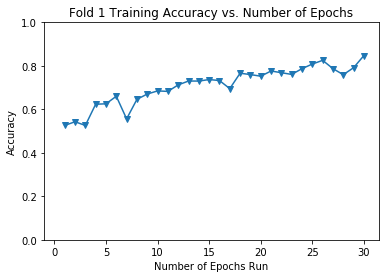

In [53]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_1f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 1 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

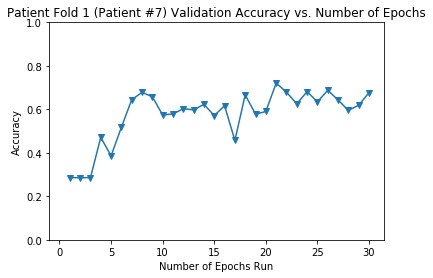

In [54]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_1f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 1 (Patient #7) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [55]:
# Second Patient (Patient #4)
graph_seed = 42
reset_graph(graph_seed)

In [56]:
# Second Validation Fold (Patient #4)
X_valid_fold = X_sorted[validation_2]
y_valid_fold = y_sorted[validation_2]

In [57]:
X_valid_fold.shape

(532, 251502)

In [58]:
y_valid_fold.shape

(532,)

In [59]:
# Validation Cube for patient fold 2 (Patient #4)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_2_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [60]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [61]:
# Second Training Fold (Patients 13,10,1,9,6,3,2,14,5,8,12,7)
X_train_fold = X_sorted[training_2]
y_train_fold = y_sorted[training_2]

In [62]:
X_train_fold.shape

(6118, 251502)

In [63]:
y_train_fold.shape

(6118,)

In [64]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [65]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [66]:
n_iterations_per_epoch

61

In [67]:
# Trains the CNN
acc_train_mat_2f = []
acc_valid_mat_2f = []

y_pred_valid_mat_2f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_2f.append(acc_train)
        acc_valid_mat_2f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_2f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_2f.append(y_pred_valid_2f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_2fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 19:29:14.304419 

Epoch 0
Last Batch accuracy:  47.00 %, Training accuracy:  51.24 %, Validation accuracy:  48.12 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  49  seconds.
Epoch 1
Last Batch accuracy:  50.00 %, Training accuracy:  51.83 %, Validation accuracy:  47.74 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  36  seconds.
Epoch 2
Last Batch accuracy:  60.00 %, Training accuracy:  61.25 %, Validation accuracy:  52.44 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  22  seconds.
Epoch 3
Last Batch accuracy:  55.00 %, Training accuracy:  50.11 %, Validation accuracy:  46.80 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  8  seconds.
Epoch 4
Last Batch accuracy:  58.00 %, Training accuracy:  62.59 %, Validation accuracy:  50.56 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  55  seconds.
Epoch 5
Last Batch accuracy:  72.00 %, Training accuracy:  68.34 %, Validation accuracy:  57.89 %
Time t

In [68]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Second Patient Fold (Patient #4) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Second Patient Fold (Patient #4) of CV took 0  hours,  23  minutes, and  14  seconds to train.



In [69]:
valid_accuracy_2f = accuracy_score(y_valid_fold, y_pred_valid_2f)
valid_precision_2f = precision_score(y_valid_fold, y_pred_valid_2f)
valid_recall_2f = recall_score(y_valid_fold, y_pred_valid_2f)
valid_f1_2f = f1_score(y_valid_fold, y_pred_valid_2f)

print("Segment Validation Statistics, Second Patient Fold:\nAccuracy:\t\t",valid_accuracy_2f,
      "\nPrecision:\t\t",valid_precision_2f)
print("Recall:\t\t\t",valid_recall_2f,"\nF1 Score:\t\t",valid_f1_2f)

Segment Validation Statistics, Second Patient Fold:
Accuracy:		 0.45864661654135336 
Precision:		 0.4321266968325792
Recall:			 0.8377192982456141 
F1 Score:		 0.5701492537313433


In [70]:
valid_label = np.unique(y_valid_fold)
validation_cm_2f = confusion_matrix(y_valid_fold, y_pred_valid_2f, labels=valid_label) 

print("Second Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_2f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Second Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 53                251
true:Nonleasional              37                191


In [71]:
y_valid_cube_pred_2fold = group_hypercube(y_pred_valid_2f, cube_threshold, 
                                          validation_2_key, total_bands)

In [72]:
valid_accuracy_cube_2f = accuracy_score(y_valid_cube, y_valid_cube_pred_2fold)
valid_precision_cube_2f = precision_score(y_valid_cube, y_valid_cube_pred_2fold)
valid_recall_cube_2f = recall_score(y_valid_cube, y_valid_cube_pred_2fold)
valid_f1_cube_2f = f1_score(y_valid_cube, y_valid_cube_pred_2fold)

print("Validation Model Hypercube Statistics, Second Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_2f,
      "\nHypercube Precision:\t\t",valid_precision_cube_2f)
print("Hypercube Recall: \t\t",valid_recall_cube_2f,"\nHypercube F1 Score:\t\t",valid_f1_cube_2f)

Validation Model Hypercube Statistics, Second Patient Fold:
Hypercube Accuracy:		 0.5 
Hypercube Precision:		 0.46153846153846156
Hypercube Recall: 		 1.0 
Hypercube F1 Score:		 0.631578947368421


In [73]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_2f = confusion_matrix(y_valid_cube, y_valid_cube_pred_2fold, labels=valid_cube_label) 

print("Second Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_2f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Second Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  1                  7
true:Nonleasional               0                  6


In [74]:
avg_v_acc_2f, avg_v_prec_2f, avg_v_re_2f, avg_v_f1_2f, avg_v_cm_2f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_2f, y_valid_fold)

In [75]:
print("Average (20 Epochs) Segment Validation Statistics, Second Patient Fold:\nAccuracy:\t\t",avg_v_acc_2f,
      "\nPrecision:\t\t",avg_v_prec_2f)
print("Recall:\t\t\t",avg_v_re_2f,"\nF1 Score:\t\t",avg_v_f1_2f)

Average (20 Epochs) Segment Validation Statistics, Second Patient Fold:
Accuracy:		 0.6376879699248119 
Precision:		 0.5829869665488623
Recall:			 0.525438596491228 
F1 Score:		 0.548677250121253


In [76]:
avgvalid_cm_2f =  avg_v_cm_2f.groupby(avg_v_cm_2f.index)

avgvalid_cm_2f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,219.45,84.55
true:Nonleasional,108.20,119.80


In [77]:
avg_vc_acc_2f, avg_vc_prec_2f, avg_vc_re_2f, avg_vc_f1_2f, avg_vc_cm_2f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_2f, 
                                                                                             cube_threshold, 
                                                                                             validation_2_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Second Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_2f,
      "\nHypercube Precision:\t\t",avg_vc_prec_2f)
print("Hypercube Recall:\t\t",avg_vc_re_2f,"\nHypercube F1 Score:\t\t",avg_vc_f1_2f)


Average (20 Epochs) Hypercube Validation Statistics, Second Patient Fold:
Hypercube Accuracy:		 0.7214285714285715 
Hypercube Precision:		 0.7398809523809524
Hypercube Recall:		 0.5416666666666665 
Hypercube F1 Score:		 0.6203807303807303


In [78]:
avgvalid_cm_cube_2f =  avg_vc_cm_2f.groupby(avg_vc_cm_2f.index)

avgvalid_cm_cube_2f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,6.85,1.15
true:Nonleasional,2.75,3.25


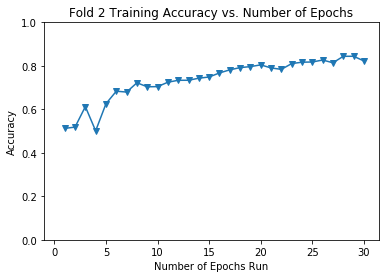

In [79]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_2f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 2 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

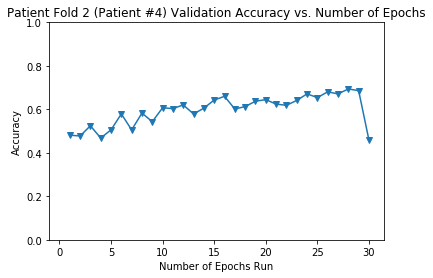

In [80]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_2f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 2 (Patient #4) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [81]:
# Third Patient (Patient #12)
graph_seed = 42
reset_graph(graph_seed)

In [82]:
# Third Validation Fold (Patient #12)
X_valid_fold = X_sorted[validation_3]
y_valid_fold = y_sorted[validation_3]

In [83]:
X_valid_fold.shape

(722, 251502)

In [84]:
y_valid_fold.shape

(722,)

In [85]:
# Validation Cube for patient fold 3 (Patient #12)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_3_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [86]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [87]:
# Third Training Fold (Patients 13,10,1,9,6,3,2,14,5,8,4,7)
X_train_fold = X_sorted[training_3]
y_train_fold = y_sorted[training_3]

In [88]:
X_train_fold.shape

(5928, 251502)

In [89]:
y_train_fold.shape

(5928,)

In [90]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [91]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [92]:
n_iterations_per_epoch

59

In [93]:
# Trains the CNN
acc_train_mat_3f = []
acc_valid_mat_3f = []

y_pred_valid_mat_3f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_3f.append(acc_train)
        acc_valid_mat_3f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_3f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_3f.append(y_pred_valid_3f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_3fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 19:53:33.505696 

Epoch 0
Last Batch accuracy:  55.00 %, Training accuracy:  57.73 %, Validation accuracy:  76.87 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  47  seconds.
Epoch 1
Last Batch accuracy:  50.00 %, Training accuracy:  52.88 %, Validation accuracy:  52.63 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  32  seconds.
Epoch 2
Last Batch accuracy:  57.00 %, Training accuracy:  58.13 %, Validation accuracy:  78.95 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  16  seconds.
Epoch 3
Last Batch accuracy:  48.00 %, Training accuracy:  55.50 %, Validation accuracy:  50.00 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  1  seconds.
Epoch 4
Last Batch accuracy:  64.00 %, Training accuracy:  61.61 %, Validation accuracy:  55.82 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  46  seconds.
Epoch 5
Last Batch accuracy:  63.00 %, Training accuracy:  66.01 %, Validation accuracy:  75.48 %
Time t

In [94]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Third Patient Fold (Patient #12) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Third Patient Fold (Patient #12) of CV took 0  hours,  22  minutes, and  16  seconds to train.



In [95]:
valid_accuracy_3f = accuracy_score(y_valid_fold, y_pred_valid_3f)
valid_precision_3f = precision_score(y_valid_fold, y_pred_valid_3f)
valid_recall_3f = recall_score(y_valid_fold, y_pred_valid_3f)
valid_f1_3f = f1_score(y_valid_fold, y_pred_valid_3f)

print("Segment Validation Statistics, Third Patient Fold:\nAccuracy:\t\t",valid_accuracy_3f,
      "\nPrecision:\t\t",valid_precision_3f)
print("Recall:\t\t\t",valid_recall_3f,"\nF1 Score:\t\t",valid_f1_3f)

Segment Validation Statistics, Third Patient Fold:
Accuracy:		 0.7202216066481995 
Precision:		 0.6851851851851852
Recall:			 0.7573099415204678 
F1 Score:		 0.7194444444444443


In [96]:
valid_label = np.unique(y_valid_fold)
validation_cm_3f = confusion_matrix(y_valid_fold, y_pred_valid_3f, labels=valid_label) 

print("Third Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_3f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Third Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                261                119
true:Nonleasional              83                259


In [97]:
y_valid_cube_pred_3fold = group_hypercube(y_pred_valid_3f, cube_threshold, 
                                          validation_3_key, total_bands)

In [98]:
valid_accuracy_cube_3f = accuracy_score(y_valid_cube, y_valid_cube_pred_3fold)
valid_precision_cube_3f = precision_score(y_valid_cube, y_valid_cube_pred_3fold)
valid_recall_cube_3f = recall_score(y_valid_cube, y_valid_cube_pred_3fold)
valid_f1_cube_3f = f1_score(y_valid_cube, y_valid_cube_pred_3fold)

print("Validation Model Hypercube Statistics, Third Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_3f,
      "\nHypercube Precision:\t\t",valid_precision_cube_3f)
print("Hypercube Recall: \t\t",valid_recall_cube_3f,"\nHypercube F1 Score:\t\t",valid_f1_cube_3f)

Validation Model Hypercube Statistics, Third Patient Fold:
Hypercube Accuracy:		 0.6842105263157895 
Hypercube Precision:		 0.6363636363636364
Hypercube Recall: 		 0.7777777777777778 
Hypercube F1 Score:		 0.7000000000000001


In [99]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_3f = confusion_matrix(y_valid_cube, y_valid_cube_pred_3fold, labels=valid_cube_label) 

print("Third Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_3f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Third Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  6                  4
true:Nonleasional               2                  7


In [100]:
avg_v_acc_3f, avg_v_prec_3f, avg_v_re_3f, avg_v_f1_3f, avg_v_cm_3f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_3f, y_valid_fold)

In [101]:
print("Average (20 Epochs) Segment Validation Statistics, Third Patient Fold:\nAccuracy:\t\t",avg_v_acc_3f,
      "\nPrecision:\t\t",avg_v_prec_3f)
print("Recall:\t\t\t",avg_v_re_3f,"\nF1 Score:\t\t",avg_v_f1_3f)

Average (20 Epochs) Segment Validation Statistics, Third Patient Fold:
Accuracy:		 0.7263157894736844 
Precision:		 0.7371366464848418
Recall:			 0.6883040935672515 
F1 Score:		 0.700930298083216


In [102]:
avgvalid_cm_3f =  avg_v_cm_3f.groupby(avg_v_cm_3f.index)

avgvalid_cm_3f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,289.0,91.0
true:Nonleasional,106.6,235.4


In [103]:
avg_vc_acc_3f, avg_vc_prec_3f, avg_vc_re_3f, avg_vc_f1_3f, avg_vc_cm_3f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_3f, 
                                                                                             cube_threshold, 
                                                                                             validation_3_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Third Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_3f,
      "\nHypercube Precision:\t\t",avg_vc_prec_3f)
print("Hypercube Recall:\t\t",avg_vc_re_3f,"\nHypercube F1 Score:\t\t",avg_vc_f1_3f)


Average (20 Epochs) Hypercube Validation Statistics, Third Patient Fold:
Hypercube Accuracy:		 0.7184210526315788 
Hypercube Precision:		 0.7369769119769118
Hypercube Recall:		 0.6888888888888889 
Hypercube F1 Score:		 0.6958346847510934


In [104]:
avgvalid_cm_cube_3f =  avg_vc_cm_3f.groupby(avg_vc_cm_3f.index)

avgvalid_cm_cube_3f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,7.45,2.55
true:Nonleasional,2.80,6.20


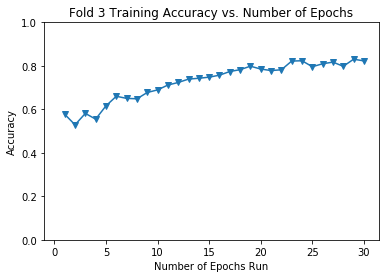

In [105]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_3f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 3 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

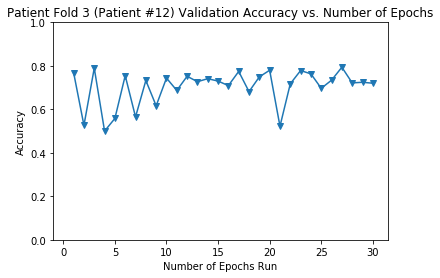

In [106]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_3f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 3 (Patient #12) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [107]:
# Fourth Patient (Patient #8)
graph_seed = 42
reset_graph(graph_seed)

In [108]:
# Fourth Validation Fold (Patient #8)
X_valid_fold = X_sorted[validation_4]
y_valid_fold = y_sorted[validation_4]

In [109]:
X_valid_fold.shape

(570, 251502)

In [110]:
y_valid_fold.shape

(570,)

In [111]:
# Validation Cube for patient fold 4 (Patient #8)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_4_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [112]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [113]:
# Fourth Training Fold (Patients 13,10,1,9,6,3,2,14,5,12,4,7)
X_train_fold = X_sorted[training_4]
y_train_fold = y_sorted[training_4]

In [114]:
X_train_fold.shape

(6080, 251502)

In [115]:
y_train_fold.shape

(6080,)

In [116]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [117]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [118]:
n_iterations_per_epoch

60

In [119]:
# Trains the CNN
acc_train_mat_4f = []
acc_valid_mat_4f = []

y_pred_valid_mat_4f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_4f.append(acc_train)
        acc_valid_mat_4f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_4f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_4f.append(y_pred_valid_4f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_4fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 20:16:53.835449 

Epoch 0
Last Batch accuracy:  44.00 %, Training accuracy:  50.62 %, Validation accuracy:  40.00 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  48  seconds.
Epoch 1
Last Batch accuracy:  61.00 %, Training accuracy:  52.86 %, Validation accuracy:  60.00 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  35  seconds.
Epoch 2
Last Batch accuracy:  67.00 %, Training accuracy:  65.16 %, Validation accuracy:  6.49 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  21  seconds.
Epoch 3
Last Batch accuracy:  51.00 %, Training accuracy:  56.09 %, Validation accuracy:  34.04 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  7  seconds.
Epoch 4
Last Batch accuracy:  70.00 %, Training accuracy:  72.63 %, Validation accuracy:  8.25 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  53  seconds.
Epoch 5
Last Batch accuracy:  76.00 %, Training accuracy:  72.75 %, Validation accuracy:  20.53 %
Time tra

In [120]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Fourth Patient Fold (Patient #8) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Fourth Patient Fold (Patient #8) of CV took 0  hours,  22  minutes, and  56  seconds to train.



In [121]:
valid_accuracy_4f = accuracy_score(y_valid_fold, y_pred_valid_4f)
valid_precision_4f = precision_score(y_valid_fold, y_pred_valid_4f)
valid_recall_4f = recall_score(y_valid_fold, y_pred_valid_4f)
valid_f1_4f = f1_score(y_valid_fold, y_pred_valid_4f)

print("Segment Validation Statistics, Fourth Patient Fold:\nAccuracy:\t\t",valid_accuracy_4f,
      "\nPrecision:\t\t",valid_precision_4f)
print("Recall:\t\t\t",valid_recall_4f,"\nF1 Score:\t\t",valid_f1_4f)

Segment Validation Statistics, Fourth Patient Fold:
Accuracy:		 0.21578947368421053 
Precision:		 0.0
Recall:			 0.0 
F1 Score:		 0.0


In [122]:
valid_label = np.unique(y_valid_fold)
validation_cm_4f = confusion_matrix(y_valid_fold, y_pred_valid_4f, labels=valid_label) 

print("Fourth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_4f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Fourth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                123                219
true:Nonleasional             228                  0


In [123]:
y_valid_cube_pred_4fold = group_hypercube(y_pred_valid_4f, cube_threshold, 
                                          validation_4_key, total_bands)

In [124]:
valid_accuracy_cube_4f = accuracy_score(y_valid_cube, y_valid_cube_pred_4fold)
valid_precision_cube_4f = precision_score(y_valid_cube, y_valid_cube_pred_4fold)
valid_recall_cube_4f = recall_score(y_valid_cube, y_valid_cube_pred_4fold)
valid_f1_cube_4f = f1_score(y_valid_cube, y_valid_cube_pred_4fold)

print("Validation Model Hypercube Statistics, Fourth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_4f,
      "\nHypercube Precision:\t\t",valid_precision_cube_4f)
print("Hypercube Recall: \t\t",valid_recall_cube_4f,"\nHypercube F1 Score:\t\t",valid_f1_cube_4f)

Validation Model Hypercube Statistics, Fourth Patient Fold:
Hypercube Accuracy:		 0.13333333333333333 
Hypercube Precision:		 0.0
Hypercube Recall: 		 0.0 
Hypercube F1 Score:		 0.0


In [125]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_4f = confusion_matrix(y_valid_cube, y_valid_cube_pred_4fold, labels=valid_cube_label) 

print("Fourth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_4f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Fourth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  2                  7
true:Nonleasional               6                  0


In [126]:
avg_v_acc_4f, avg_v_prec_4f, avg_v_re_4f, avg_v_f1_4f, avg_v_cm_4f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_4f, y_valid_fold)

In [127]:
print("Average (20 Epochs) Segment Validation Statistics, Fourth Patient Fold:\nAccuracy:\t\t",avg_v_acc_4f,
      "\nPrecision:\t\t",avg_v_prec_4f)
print("Recall:\t\t\t",avg_v_re_4f,"\nF1 Score:\t\t",avg_v_f1_4f)

Average (20 Epochs) Segment Validation Statistics, Fourth Patient Fold:
Accuracy:		 0.18315789473684213 
Precision:		 0.027133943275382644
Recall:			 0.036622807017543856 
F1 Score:		 0.031088694402195464


In [128]:
avgvalid_cm_4f =  avg_v_cm_4f.groupby(avg_v_cm_4f.index)

avgvalid_cm_4f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,96.05,245.95
true:Nonleasional,219.65,8.35


In [129]:
avg_vc_acc_4f, avg_vc_prec_4f, avg_vc_re_4f, avg_vc_f1_4f, avg_vc_cm_4f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_4f, 
                                                                                             cube_threshold, 
                                                                                             validation_4_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Fourth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_4f,
      "\nHypercube Precision:\t\t",avg_vc_prec_4f)
print("Hypercube Recall:\t\t",avg_vc_re_4f,"\nHypercube F1 Score:\t\t",avg_vc_f1_4f)


Average (20 Epochs) Hypercube Validation Statistics, Fourth Patient Fold:
Hypercube Accuracy:		 0.1366666666666667 
Hypercube Precision:		 0.017361111111111112
Hypercube Recall:		 0.025 
Hypercube F1 Score:		 0.020476190476190474


In [130]:
avgvalid_cm_cube_4f =  avg_vc_cm_4f.groupby(avg_vc_cm_4f.index)

avgvalid_cm_cube_4f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,1.90,7.10
true:Nonleasional,5.85,0.15


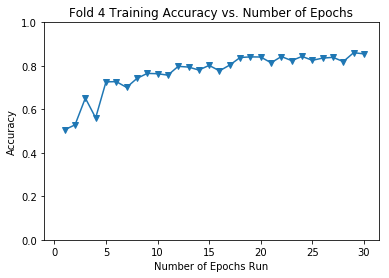

In [131]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_4f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 4 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

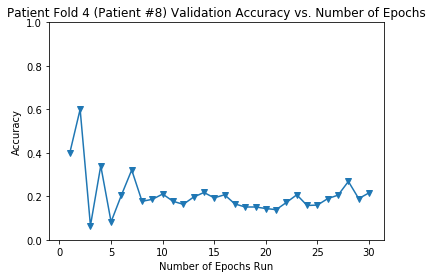

In [132]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_4f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 4 (Patient #8) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [133]:
# Fifth Patient (Patient #5)
graph_seed = 42
reset_graph(graph_seed)

In [134]:
# Fifth Validation Fold (Patient #5)
X_valid_fold = X_sorted[validation_5]
y_valid_fold = y_sorted[validation_5]

In [135]:
X_valid_fold.shape

(684, 251502)

In [136]:
y_valid_fold.shape

(684,)

In [137]:
# Validation Cube for patient fold 5 (Patient #5)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_5_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [138]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [139]:
# Fifth Training Fold (Patients 13,10,1,9,6,3,2,14,8,12,4,7)
X_train_fold = X_sorted[training_5]
y_train_fold = y_sorted[training_5]

In [140]:
X_train_fold.shape

(5966, 251502)

In [141]:
y_train_fold.shape

(5966,)

In [142]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [143]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [144]:
n_iterations_per_epoch

59

In [145]:
# Trains the CNN
acc_train_mat_5f = []
acc_valid_mat_5f = []

y_pred_valid_mat_5f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_5f.append(acc_train)
        acc_valid_mat_5f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_5f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_5f.append(y_pred_valid_5f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_5fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 20:40:50.838892 

Epoch 0
Last Batch accuracy:  50.00 %, Training accuracy:  54.93 %, Validation accuracy:  84.36 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  48  seconds.
Epoch 1
Last Batch accuracy:  55.00 %, Training accuracy:  52.04 %, Validation accuracy:  53.65 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  33  seconds.
Epoch 2
Last Batch accuracy:  64.00 %, Training accuracy:  58.00 %, Validation accuracy:  80.70 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  18  seconds.
Epoch 3
Last Batch accuracy:  49.00 %, Training accuracy:  53.00 %, Validation accuracy:  70.61 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  3  seconds.
Epoch 4
Last Batch accuracy:  62.00 %, Training accuracy:  60.73 %, Validation accuracy:  80.41 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  47  seconds.
Epoch 5
Last Batch accuracy:  64.00 %, Training accuracy:  59.86 %, Validation accuracy:  85.09 %
Time t

In [146]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Fifth Patient Fold (Patient #5) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Fifth Patient Fold (Patient #5) of CV took 0  hours,  22  minutes, and  22  seconds to train.



In [147]:
valid_accuracy_5f = accuracy_score(y_valid_fold, y_pred_valid_5f)
valid_precision_5f = precision_score(y_valid_fold, y_pred_valid_5f)
valid_recall_5f = recall_score(y_valid_fold, y_pred_valid_5f)
valid_f1_5f = f1_score(y_valid_fold, y_pred_valid_5f)

print("Segment Validation Statistics, Fifth Patient Fold:\nAccuracy:\t\t",valid_accuracy_5f,
      "\nPrecision:\t\t",valid_precision_5f)
print("Recall:\t\t\t",valid_recall_5f,"\nF1 Score:\t\t",valid_f1_5f)

Segment Validation Statistics, Fifth Patient Fold:
Accuracy:		 0.685672514619883 
Precision:		 0.7259786476868327
Recall:			 0.5964912280701754 
F1 Score:		 0.6548956661316212


In [148]:
valid_label = np.unique(y_valid_fold)
validation_cm_5f = confusion_matrix(y_valid_fold, y_pred_valid_5f, labels=valid_label) 

print("Fifth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_5f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Fifth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                265                 77
true:Nonleasional             138                204


In [149]:
y_valid_cube_pred_5fold = group_hypercube(y_pred_valid_5f, cube_threshold, 
                                          validation_5_key, total_bands)

In [150]:
valid_accuracy_cube_5f = accuracy_score(y_valid_cube, y_valid_cube_pred_5fold)
valid_precision_cube_5f = precision_score(y_valid_cube, y_valid_cube_pred_5fold)
valid_recall_cube_5f = recall_score(y_valid_cube, y_valid_cube_pred_5fold)
valid_f1_cube_5f = f1_score(y_valid_cube, y_valid_cube_pred_5fold)

print("Validation Model Hypercube Statistics, Fifth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_5f,
      "\nHypercube Precision:\t\t",valid_precision_cube_5f)
print("Hypercube Recall: \t\t",valid_recall_cube_5f,"\nHypercube F1 Score:\t\t",valid_f1_cube_5f)

Validation Model Hypercube Statistics, Fifth Patient Fold:
Hypercube Accuracy:		 0.6666666666666666 
Hypercube Precision:		 0.6666666666666666
Hypercube Recall: 		 0.6666666666666666 
Hypercube F1 Score:		 0.6666666666666666


In [151]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_5f = confusion_matrix(y_valid_cube, y_valid_cube_pred_5fold, labels=valid_cube_label) 

print("Fifth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_5f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Fifth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  6                  3
true:Nonleasional               3                  6


In [152]:
avg_v_acc_5f, avg_v_prec_5f, avg_v_re_5f, avg_v_f1_5f, avg_v_cm_5f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_5f, y_valid_fold)

In [153]:
print("Average (20 Epochs) Segment Validation Statistics, Fifth Patient Fold:\nAccuracy:\t\t",avg_v_acc_5f,
      "\nPrecision:\t\t",avg_v_prec_5f)
print("Recall:\t\t\t",avg_v_re_5f,"\nF1 Score:\t\t",avg_v_f1_5f)

Average (20 Epochs) Segment Validation Statistics, Fifth Patient Fold:
Accuracy:		 0.7402046783625731 
Precision:		 0.7825336770673063
Recall:			 0.6608187134502924 
F1 Score:		 0.7115023597640081


In [154]:
avgvalid_cm_5f =  avg_v_cm_5f.groupby(avg_v_cm_5f.index)

avgvalid_cm_5f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,280.3,61.7
true:Nonleasional,116.0,226.0


In [155]:
avg_vc_acc_5f, avg_vc_prec_5f, avg_vc_re_5f, avg_vc_f1_5f, avg_vc_cm_5f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_5f, 
                                                                                             cube_threshold, 
                                                                                             validation_5_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Fifth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_5f,
      "\nHypercube Precision:\t\t",avg_vc_prec_5f)
print("Hypercube Recall:\t\t",avg_vc_re_5f,"\nHypercube F1 Score:\t\t",avg_vc_f1_5f)


Average (20 Epochs) Hypercube Validation Statistics, Fifth Patient Fold:
Hypercube Accuracy:		 0.7694444444444445 
Hypercube Precision:		 0.8403174603174604
Hypercube Recall:		 0.6666666666666667 
Hypercube F1 Score:		 0.7364563369207333


In [156]:
avgvalid_cm_cube_5f =  avg_vc_cm_5f.groupby(avg_vc_cm_5f.index)

avgvalid_cm_cube_5f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,7.85,1.15
true:Nonleasional,3.00,6.00


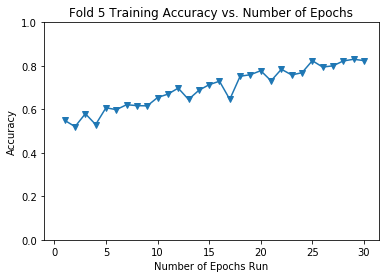

In [157]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_5f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 5 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

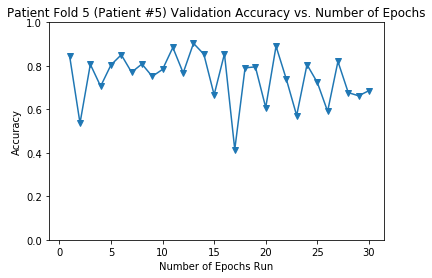

In [158]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_5f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 5 (Patient #5) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [159]:
# Sixth Patient (Patient #14)
graph_seed = 42
reset_graph(graph_seed)

In [160]:
# Sixth Validation Fold (Patient #14)
X_valid_fold = X_sorted[validation_6]
y_valid_fold = y_sorted[validation_6]

In [161]:
X_valid_fold.shape

(380, 251502)

In [162]:
y_valid_fold.shape

(380,)

In [163]:
# Validation Cube for fold 6 (Patient #14)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_6_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [164]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [165]:
# Second Training Fold (Patients 13,10,1,9,6,3,2,5,8,12,4,7)
X_train_fold = X_sorted[training_6]
y_train_fold = y_sorted[training_6]

In [166]:
X_train_fold.shape

(6270, 251502)

In [167]:
y_train_fold.shape

(6270,)

In [168]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [169]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [170]:
n_iterations_per_epoch

62

In [171]:
# Trains the CNN
acc_train_mat_6f = []
acc_valid_mat_6f = []

y_pred_valid_mat_6f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_6f.append(acc_train)
        acc_valid_mat_6f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_6f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_6f.append(y_pred_valid_6f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_6fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 21:04:11.203001 

Epoch 0
Last Batch accuracy:  50.00 %, Training accuracy:  52.68 %, Validation accuracy:  20.26 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  48  seconds.
Epoch 1
Last Batch accuracy:  56.00 %, Training accuracy:  51.63 %, Validation accuracy:  20.26 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  34  seconds.
Epoch 2
Last Batch accuracy:  63.00 %, Training accuracy:  52.28 %, Validation accuracy:  23.42 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  20  seconds.
Epoch 3
Last Batch accuracy:  50.00 %, Training accuracy:  55.01 %, Validation accuracy:  20.53 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  7  seconds.
Epoch 4
Last Batch accuracy:  63.00 %, Training accuracy:  56.76 %, Validation accuracy:  30.79 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  53  seconds.
Epoch 5
Last Batch accuracy:  63.00 %, Training accuracy:  60.46 %, Validation accuracy:  36.32 %
Time t

In [172]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Sixth Patient Fold (Patient #14) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Sixth Patient Fold (Patient #14) of CV took 0  hours,  23  minutes, and  11  seconds to train.



In [173]:
valid_accuracy_6f = accuracy_score(y_valid_fold, y_pred_valid_6f)
valid_precision_6f = precision_score(y_valid_fold, y_pred_valid_6f)
valid_recall_6f = recall_score(y_valid_fold, y_pred_valid_6f)
valid_f1_6f = f1_score(y_valid_fold, y_pred_valid_6f)

print("Segment Validation Statistics, Sixth Patient Fold:\nAccuracy:\t\t",valid_accuracy_6f,
      "\nPrecision:\t\t",valid_precision_6f)
print("Recall:\t\t\t",valid_recall_6f,"\nF1 Score:\t\t",valid_f1_6f)

Segment Validation Statistics, Sixth Patient Fold:
Accuracy:		 0.7684210526315789 
Precision:		 0.7934782608695652
Recall:			 0.9605263157894737 
F1 Score:		 0.869047619047619


In [174]:
valid_label = np.unique(y_valid_fold)
validation_cm_6f = confusion_matrix(y_valid_fold, y_pred_valid_6f, labels=valid_label) 

print("Sixth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_6f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Sixth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                  0                 76
true:Nonleasional              12                292


In [175]:
y_valid_cube_pred_6fold = group_hypercube(y_pred_valid_6f, cube_threshold, 
                                          validation_6_key, total_bands)

In [176]:
valid_accuracy_cube_6f = accuracy_score(y_valid_cube, y_valid_cube_pred_6fold)
valid_precision_cube_6f = precision_score(y_valid_cube, y_valid_cube_pred_6fold)
valid_recall_cube_6f = recall_score(y_valid_cube, y_valid_cube_pred_6fold)
valid_f1_cube_6f = f1_score(y_valid_cube, y_valid_cube_pred_6fold)

print("Validation Model Hypercube Statistics, Sixth Patient Fold (Patient #14):\nHypercube Accuracy:\t\t",valid_accuracy_cube_6f,
      "\nHypercube Precision:\t\t",valid_precision_cube_6f)
print("Hypercube Recall: \t\t",valid_recall_cube_6f,"\nHypercube F1 Score:\t\t",valid_f1_cube_6f)

Validation Model Hypercube Statistics, Sixth Patient Fold (Patient #14):
Hypercube Accuracy:		 0.8 
Hypercube Precision:		 0.8
Hypercube Recall: 		 1.0 
Hypercube F1 Score:		 0.888888888888889


In [177]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_6f = confusion_matrix(y_valid_cube, y_valid_cube_pred_6fold, labels=valid_cube_label) 

print("Sixth Patient Fold (Patient #14) Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_6f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Sixth Patient Fold (Patient #14) Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  0                  2
true:Nonleasional               0                  8


In [178]:
avg_v_acc_6f, avg_v_prec_6f, avg_v_re_6f, avg_v_f1_6f, avg_v_cm_6f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_6f, y_valid_fold)

In [179]:
print("Average (20 Epochs) Segment Validation Statistics, Sixth Patient Fold:\nAccuracy:\t\t",avg_v_acc_6f,
      "\nPrecision:\t\t",avg_v_prec_6f)
print("Recall:\t\t\t",avg_v_re_6f,"\nF1 Score:\t\t",avg_v_f1_6f)

Average (20 Epochs) Segment Validation Statistics, Sixth Patient Fold:
Accuracy:		 0.7146052631578947 
Precision:		 0.7895297346051444
Recall:			 0.8771381578947368 
F1 Score:		 0.8292255436149594


In [180]:
avgvalid_cm_6f =  avg_v_cm_6f.groupby(avg_v_cm_6f.index)

avgvalid_cm_6f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,4.90,71.10
true:Nonleasional,37.35,266.65


In [181]:
avg_vc_acc_6f, avg_vc_prec_6f, avg_vc_re_6f, avg_vc_f1_6f, avg_vc_cm_6f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_6f, 
                                                                                             cube_threshold, 
                                                                                             validation_6_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Sixth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_6f,
      "\nHypercube Precision:\t\t",avg_vc_prec_6f)
print("Hypercube Recall:\t\t",avg_vc_re_6f,"\nHypercube F1 Score:\t\t",avg_vc_f1_6f)


Average (20 Epochs) Hypercube Validation Statistics, Sixth Patient Fold:
Hypercube Accuracy:		 0.7800000000000001 
Hypercube Precision:		 0.7987500000000003
Hypercube Recall:		 0.96875 
Hypercube F1 Score:		 0.8743055555555557


In [182]:
avgvalid_cm_cube_6f =  avg_vc_cm_6f.groupby(avg_vc_cm_6f.index)

avgvalid_cm_cube_6f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,0.05,1.95
true:Nonleasional,0.25,7.75


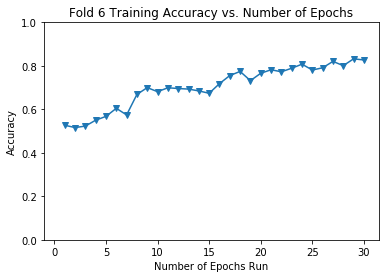

In [183]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_6f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 6 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

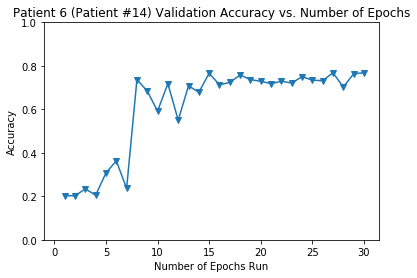

In [184]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_6f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient 6 (Patient #14) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [185]:
# Seventh Patient (Patient 2)
graph_seed = 42
reset_graph(graph_seed)

In [186]:
# Seventh Validation Fold (Patient 2)
X_valid_fold = X_sorted[validation_7]
y_valid_fold = y_sorted[validation_7]

In [187]:
X_valid_fold.shape

(342, 251502)

In [188]:
y_valid_fold.shape

(342,)

In [189]:
# Validation Cube for patient fold 7 (Patient #2)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_7_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [190]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [191]:
# Third Training Fold (Patients 13,10,1,9,6,3,14,5,8,12,4,7)
X_train_fold = X_sorted[training_7]
y_train_fold = y_sorted[training_7]

In [192]:
X_train_fold.shape

(6308, 251502)

In [193]:
y_train_fold.shape

(6308,)

In [194]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [195]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [196]:
n_iterations_per_epoch

63

In [197]:
# Trains the CNN
acc_train_mat_7f = []
acc_valid_mat_7f = []

y_pred_valid_mat_7f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_7f.append(acc_train)
        acc_valid_mat_7f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_7f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_7f.append(y_pred_valid_7f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_7fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 21:28:27.394060 

Epoch 0
Last Batch accuracy:  57.00 %, Training accuracy:  60.45 %, Validation accuracy:  44.44 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  49  seconds.
Epoch 1
Last Batch accuracy:  47.00 %, Training accuracy:  59.65 %, Validation accuracy:  43.57 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  36  seconds.
Epoch 2
Last Batch accuracy:  64.00 %, Training accuracy:  63.13 %, Validation accuracy:  44.44 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  23  seconds.
Epoch 3
Last Batch accuracy:  61.00 %, Training accuracy:  62.87 %, Validation accuracy:  45.03 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  9  seconds.
Epoch 4
Last Batch accuracy:  66.00 %, Training accuracy:  68.58 %, Validation accuracy:  69.01 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  56  seconds.
Epoch 5
Last Batch accuracy:  71.00 %, Training accuracy:  68.56 %, Validation accuracy:  44.44 %
Time t

In [198]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Seventh Patient Fold (Patient #2) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Seventh Patient Fold (Patient #2) of CV took 0  hours,  23  minutes, and  1  seconds to train.



In [199]:
valid_accuracy_7f = accuracy_score(y_valid_fold, y_pred_valid_7f)
valid_precision_7f = precision_score(y_valid_fold, y_pred_valid_7f)
valid_recall_7f = recall_score(y_valid_fold, y_pred_valid_7f)
valid_f1_7f = f1_score(y_valid_fold, y_pred_valid_7f)

print("Segment Validation Statistics, Seventh Patient Fold:\nAccuracy:\t\t",valid_accuracy_7f,
      "\nPrecision:\t\t",valid_precision_7f)
print("Recall:\t\t\t",valid_recall_7f,"\nF1 Score:\t\t",valid_f1_7f)

Segment Validation Statistics, Seventh Patient Fold:
Accuracy:		 0.5555555555555556 
Precision:		 0.0
Recall:			 0.0 
F1 Score:		 0.0


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [200]:
valid_label = np.unique(y_valid_fold)
validation_cm_7f = confusion_matrix(y_valid_fold, y_pred_valid_7f, labels=valid_label) 

print("Seventh Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_7f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Seventh Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                190                  0
true:Nonleasional             152                  0


In [201]:
y_valid_cube_pred_7fold = group_hypercube(y_pred_valid_7f, cube_threshold, 
                                          validation_7_key, total_bands)

In [202]:
valid_accuracy_cube_7f = accuracy_score(y_valid_cube, y_valid_cube_pred_7fold)
valid_precision_cube_7f = precision_score(y_valid_cube, y_valid_cube_pred_7fold)
valid_recall_cube_7f = recall_score(y_valid_cube, y_valid_cube_pred_7fold)
valid_f1_cube_7f = f1_score(y_valid_cube, y_valid_cube_pred_7fold)

print("Validation Model Hypercube Statistics, Seventh Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_7f,
      "\nHypercube Precision:\t\t",valid_precision_cube_7f)
print("Hypercube Recall: \t\t",valid_recall_cube_7f,"\nHypercube F1 Score:\t\t",valid_f1_cube_7f)

Validation Model Hypercube Statistics, Seventh Patient Fold:
Hypercube Accuracy:		 0.5555555555555556 
Hypercube Precision:		 0.0
Hypercube Recall: 		 0.0 
Hypercube F1 Score:		 0.0


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [203]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_7f = confusion_matrix(y_valid_cube, y_valid_cube_pred_7fold, labels=valid_cube_label) 

print("Third Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_7f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Third Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  5                  0
true:Nonleasional               4                  0


In [204]:
avg_v_acc_7f, avg_v_prec_7f, avg_v_re_7f, avg_v_f1_7f, avg_v_cm_7f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_7f, y_valid_fold)

C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [205]:
print("Average (20 Epochs) Segment Validation Statistics, Seventh Patient Fold:\nAccuracy:\t\t",avg_v_acc_7f,
      "\nPrecision:\t\t",avg_v_prec_7f)
print("Recall:\t\t\t",avg_v_re_7f,"\nF1 Score:\t\t",avg_v_f1_7f)

Average (20 Epochs) Segment Validation Statistics, Seventh Patient Fold:
Accuracy:		 0.499561403508772 
Precision:		 0.45831103960162006
Recall:			 0.46282894736842106 
F1 Score:		 0.3387796303524638


In [206]:
avgvalid_cm_7f =  avg_v_cm_7f.groupby(avg_v_cm_7f.index)

avgvalid_cm_7f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,100.50,89.50
true:Nonleasional,81.65,70.35


In [207]:
avg_vc_acc_7f, avg_vc_prec_7f, avg_vc_re_7f, avg_vc_f1_7f, avg_vc_cm_7f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_7f, 
                                                                                             cube_threshold, 
                                                                                             validation_7_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Third Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_7f,
      "\nHypercube Precision:\t\t",avg_vc_prec_7f)
print("Hypercube Recall:\t\t",avg_vc_re_7f,"\nHypercube F1 Score:\t\t",avg_vc_f1_7f)


Average (20 Epochs) Hypercube Validation Statistics, Third Fold:
Hypercube Accuracy:		 0.5111111111111112 
Hypercube Precision:		 0.30406746031746035
Hypercube Recall:		 0.4875 
Hypercube F1 Score:		 0.3462287712287712


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [208]:
avgvalid_cm_cube_7f =  avg_vc_cm_7f.groupby(avg_vc_cm_7f.index)

avgvalid_cm_cube_7f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,2.65,2.35
true:Nonleasional,2.05,1.95


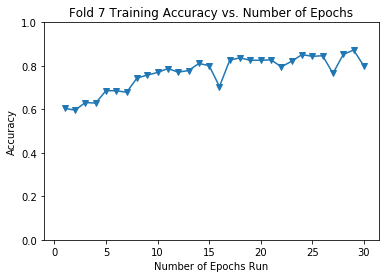

In [209]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_7f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 7 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

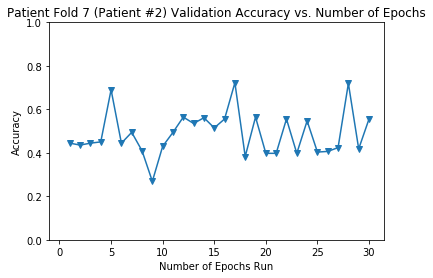

In [210]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_7f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 7 (Patient #2) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [211]:
# Eighth Patient (Patient 3)
graph_seed = 42
reset_graph(graph_seed)

In [212]:
# Eighth Patient (Patient 3)
X_valid_fold = X_sorted[validation_8]
y_valid_fold = y_sorted[validation_8]

In [213]:
X_valid_fold.shape

(304, 251502)

In [214]:
y_valid_fold.shape

(304,)

In [215]:
# Validation Cube for patient fold 8 (Patient #3)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_8_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [216]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [217]:
# Eighth Training Fold (Patients 13,10,1,9,6,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_8]
y_train_fold = y_sorted[training_8]

In [218]:
X_train_fold.shape

(6346, 251502)

In [219]:
y_train_fold.shape

(6346,)

In [220]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [221]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [222]:
n_iterations_per_epoch

63

In [223]:
# Trains the CNN
acc_train_mat_8f = []
acc_valid_mat_8f = []

y_pred_valid_mat_8f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_8f.append(acc_train)
        acc_valid_mat_8f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_8f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_8f.append(y_pred_valid_8f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_8fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 21:52:33.932462 

Epoch 0
Last Batch accuracy:  46.00 %, Training accuracy:  49.95 %, Validation accuracy:  42.43 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  48  seconds.
Epoch 1
Last Batch accuracy:  50.00 %, Training accuracy:  50.13 %, Validation accuracy:  42.76 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  34  seconds.
Epoch 2
Last Batch accuracy:  57.00 %, Training accuracy:  55.91 %, Validation accuracy:  59.87 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  21  seconds.
Epoch 3
Last Batch accuracy:  59.00 %, Training accuracy:  54.33 %, Validation accuracy:  48.68 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  7  seconds.
Epoch 4
Last Batch accuracy:  53.00 %, Training accuracy:  55.63 %, Validation accuracy:  59.21 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  53  seconds.
Epoch 5
Last Batch accuracy:  56.00 %, Training accuracy:  58.13 %, Validation accuracy:  65.79 %
Time t

In [224]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Eighth Patient Fold (Patient #3) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Eighth Patient Fold (Patient #3) of CV took 0  hours,  23  minutes, and  13  seconds to train.



In [225]:
valid_accuracy_8f = accuracy_score(y_valid_fold, y_pred_valid_8f)
valid_precision_8f = precision_score(y_valid_fold, y_pred_valid_8f)
valid_recall_8f = recall_score(y_valid_fold, y_pred_valid_8f)
valid_f1_8f = f1_score(y_valid_fold, y_pred_valid_8f)

print("Segment Validation Statistics, Eighth Patient Fold:\nAccuracy:\t\t",valid_accuracy_8f,
      "\nPrecision:\t\t",valid_precision_8f)
print("Recall:\t\t\t",valid_recall_8f,"\nF1 Score:\t\t",valid_f1_8f)

Segment Validation Statistics, Eighth Patient Fold:
Accuracy:		 0.7763157894736842 
Precision:		 0.9841269841269841
Recall:			 0.6526315789473685 
F1 Score:		 0.7848101265822786


In [226]:
valid_label = np.unique(y_valid_fold)
validation_cm_8f = confusion_matrix(y_valid_fold, y_pred_valid_8f, labels=valid_label) 

print("Eighth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_8f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Eighth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                112                  2
true:Nonleasional              66                124


In [227]:
y_valid_cube_pred_8fold = group_hypercube(y_pred_valid_8f, cube_threshold, 
                                          validation_8_key, total_bands)

In [228]:
valid_accuracy_cube_8f = accuracy_score(y_valid_cube, y_valid_cube_pred_8fold)
valid_precision_cube_8f = precision_score(y_valid_cube, y_valid_cube_pred_8fold)
valid_recall_cube_8f = recall_score(y_valid_cube, y_valid_cube_pred_8fold)
valid_f1_cube_8f = f1_score(y_valid_cube, y_valid_cube_pred_8fold)

print("Validation Model Hypercube Statistics, Eighth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_8f,
      "\nHypercube Precision:\t\t",valid_precision_cube_8f)
print("Hypercube Recall: \t\t",valid_recall_cube_8f,"\nHypercube F1 Score:\t\t",valid_f1_cube_8f)

Validation Model Hypercube Statistics, Eighth Patient Fold:
Hypercube Accuracy:		 0.75 
Hypercube Precision:		 1.0
Hypercube Recall: 		 0.6 
Hypercube F1 Score:		 0.7499999999999999


In [229]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_8f = confusion_matrix(y_valid_cube, y_valid_cube_pred_8fold, labels=valid_cube_label) 

print("Eighth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_8f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Eighth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  3                  0
true:Nonleasional               2                  3


In [230]:
avg_v_acc_8f, avg_v_prec_8f, avg_v_re_8f, avg_v_f1_8f, avg_v_cm_8f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_8f, y_valid_fold)

In [231]:
print("Average (20 Epochs) Segment Validation Statistics, Eighth Patient Fold:\nAccuracy:\t\t",avg_v_acc_8f,
      "\nPrecision:\t\t",avg_v_prec_8f)
print("Recall:\t\t\t",avg_v_re_8f,"\nF1 Score:\t\t",avg_v_f1_8f)

Average (20 Epochs) Segment Validation Statistics, Eighth Patient Fold:
Accuracy:		 0.8039473684210527 
Precision:		 0.9386786756570243
Recall:			 0.7328947368421053 
F1 Score:		 0.8190087265319022


In [232]:
avgvalid_cm_8f =  avg_v_cm_8f.groupby(avg_v_cm_8f.index)

avgvalid_cm_8f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,105.15,8.85
true:Nonleasional,50.75,139.25


In [233]:
avg_vc_acc_8f, avg_vc_prec_8f, avg_vc_re_8f, avg_vc_f1_8f, avg_vc_cm_8f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_8f, 
                                                                                             cube_threshold, 
                                                                                             validation_8_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Eighth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_8f,
      "\nHypercube Precision:\t\t",avg_vc_prec_8f)
print("Hypercube Recall:\t\t",avg_vc_re_8f,"\nHypercube F1 Score:\t\t",avg_vc_f1_8f)


Average (20 Epochs) Hypercube Validation Statistics, Eighth Patient Fold:
Hypercube Accuracy:		 0.84375 
Hypercube Precision:		 1.0
Hypercube Recall:		 0.75 
Hypercube F1 Score:		 0.8527777777777779


In [234]:
avgvalid_cm_cube_8f =  avg_vc_cm_8f.groupby(avg_vc_cm_8f.index)

avgvalid_cm_cube_8f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,3.00,0.00
true:Nonleasional,1.25,3.75


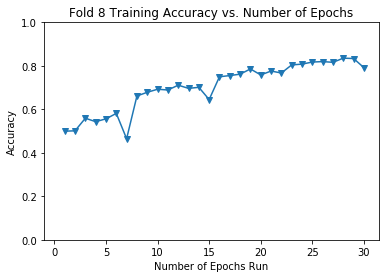

In [235]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_8f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 8 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

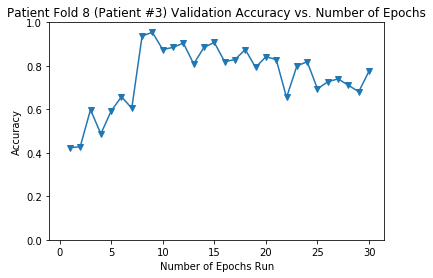

In [236]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_8f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 8 (Patient #3) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [237]:
# Ninth Patient (Patient #6)
graph_seed = 42
reset_graph(graph_seed)

In [238]:
# Ninth Validation Fold (Patient #6)
X_valid_fold = X_sorted[validation_9]
y_valid_fold = y_sorted[validation_9]

In [239]:
X_valid_fold.shape

(380, 251502)

In [240]:
y_valid_fold.shape

(380,)

In [241]:
# Validation Cube for patient fold 9 (Patient #6)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_9_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [242]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [243]:
# Fifth Training Fold (Patients 13,10,1,9,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_9]
y_train_fold = y_sorted[training_9]

In [244]:
X_train_fold.shape

(6270, 251502)

In [245]:
y_train_fold.shape

(6270,)

In [246]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [247]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [248]:
n_iterations_per_epoch

62

In [249]:
# Trains the CNN
acc_train_mat_9f = []
acc_valid_mat_9f = []

y_pred_valid_mat_9f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_9f.append(acc_train)
        acc_valid_mat_9f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_9f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_9f.append(y_pred_valid_9f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_9fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 22:16:52.272611 

Epoch 0
Last Batch accuracy:  45.00 %, Training accuracy:  52.06 %, Validation accuracy:  40.00 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  47  seconds.
Epoch 1
Last Batch accuracy:  53.00 %, Training accuracy:  50.43 %, Validation accuracy:  41.84 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  34  seconds.
Epoch 2
Last Batch accuracy:  63.00 %, Training accuracy:  54.63 %, Validation accuracy:  41.05 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  21  seconds.
Epoch 3
Last Batch accuracy:  52.00 %, Training accuracy:  58.21 %, Validation accuracy:  41.32 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  7  seconds.
Epoch 4
Last Batch accuracy:  73.00 %, Training accuracy:  64.98 %, Validation accuracy:  49.21 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  54  seconds.
Epoch 5
Last Batch accuracy:  70.00 %, Training accuracy:  65.76 %, Validation accuracy:  38.95 %
Time t

In [250]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Ninth Patient Fold (Patient #6) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Ninth Patient Fold (Patient #6) of CV took 0  hours,  23  minutes, and  23  seconds to train.



In [251]:
valid_accuracy_9f = accuracy_score(y_valid_fold, y_pred_valid_9f)
valid_precision_9f = precision_score(y_valid_fold, y_pred_valid_9f)
valid_recall_9f = recall_score(y_valid_fold, y_pred_valid_9f)
valid_f1_9f = f1_score(y_valid_fold, y_pred_valid_9f)

print("Segment Validation Statistics, Ninth Patient Fold:\nAccuracy:\t\t",valid_accuracy_9f,
      "\nPrecision:\t\t",valid_precision_9f)
print("Recall:\t\t\t",valid_recall_9f,"\nF1 Score:\t\t",valid_f1_9f)

Segment Validation Statistics, Ninth Patient Fold:
Accuracy:		 0.39473684210526316 
Precision:		 0.49557522123893805
Recall:			 0.49122807017543857 
F1 Score:		 0.49339207048458145


In [252]:
valid_label = np.unique(y_valid_fold)
validation_cm_9f = confusion_matrix(y_valid_fold, y_pred_valid_9f, labels=valid_label) 

print("Ninth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_9f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Ninth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 38                114
true:Nonleasional             116                112


In [253]:
y_valid_cube_pred_9fold = group_hypercube(y_pred_valid_9f, cube_threshold, 
                                          validation_9_key, total_bands)

In [254]:
valid_accuracy_cube_9f = accuracy_score(y_valid_cube, y_valid_cube_pred_9fold)
valid_precision_cube_9f = precision_score(y_valid_cube, y_valid_cube_pred_9fold)
valid_recall_cube_9f = recall_score(y_valid_cube, y_valid_cube_pred_9fold)
valid_f1_cube_9f = f1_score(y_valid_cube, y_valid_cube_pred_9fold)

print("Validation Model Hypercube Statistics, Ninth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_9f,
      "\nHypercube Precision:\t\t",valid_precision_cube_9f)
print("Hypercube Recall: \t\t",valid_recall_cube_9f,"\nHypercube F1 Score:\t\t",valid_f1_cube_9f)

Validation Model Hypercube Statistics, Ninth Patient Fold:
Hypercube Accuracy:		 0.3 
Hypercube Precision:		 0.4
Hypercube Recall: 		 0.3333333333333333 
Hypercube F1 Score:		 0.3636363636363636


In [255]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_9f = confusion_matrix(y_valid_cube, y_valid_cube_pred_9fold, labels=valid_cube_label) 

print("Ninth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_9f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Ninth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  1                  3
true:Nonleasional               4                  2


In [256]:
avg_v_acc_9f, avg_v_prec_9f, avg_v_re_9f, avg_v_f1_9f, avg_v_cm_9f = average_runs(averaged_runs, 
                                                                                  y_pred_valid_mat_9f, y_valid_fold)

In [257]:
print("Average (20 Epochs) Segment Validation Statistics, Ninth Patient Fold:\nAccuracy:\t\t",avg_v_acc_9f,
      "\nPrecision:\t\t",avg_v_prec_9f)
print("Recall:\t\t\t",avg_v_re_9f,"\nF1 Score:\t\t",avg_v_f1_9f)

Average (20 Epochs) Segment Validation Statistics, Ninth Patient Fold:
Accuracy:		 0.4496052631578948 
Precision:		 0.5523201372554912
Recall:			 0.41491228070175434 
F1 Score:		 0.45306054432280024


In [258]:
avgvalid_cm_9f =  avg_v_cm_9f.groupby(avg_v_cm_9f.index)

avgvalid_cm_9f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,76.25,75.75
true:Nonleasional,133.40,94.60


In [259]:
avg_vc_acc_9f, avg_vc_prec_9f, avg_vc_re_9f, avg_vc_f1_9f, avg_vc_cm_9f = average_group_runs(averaged_runs,
                                                                                             y_valid_cube, 
                                                                                             y_pred_valid_mat_9f, 
                                                                                             cube_threshold, 
                                                                                             validation_9_key, 
                                                                                             total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Ninth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_9f,
      "\nHypercube Precision:\t\t",avg_vc_prec_9f)
print("Hypercube Recall:\t\t",avg_vc_re_9f,"\nHypercube F1 Score:\t\t",avg_vc_f1_9f)


Average (20 Epochs) Hypercube Validation Statistics, Ninth Patient Fold:
Hypercube Accuracy:		 0.45 
Hypercube Precision:		 0.509047619047619
Hypercube Recall:		 0.45 
Hypercube F1 Score:		 0.4626864801864802


In [260]:
avgvalid_cm_cube_9f =  avg_vc_cm_9f.groupby(avg_vc_cm_9f.index)

avgvalid_cm_cube_9f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,1.8,2.2
true:Nonleasional,3.3,2.7


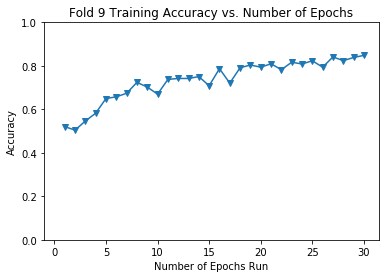

In [261]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_9f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 9 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

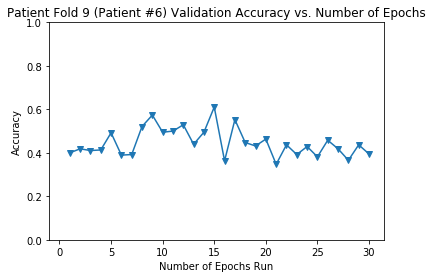

In [262]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_9f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 9 (Patient #6) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [263]:
# Tenth Patient (Patient 9)
graph_seed = 42
reset_graph(graph_seed)

In [264]:
# Tenth Patient Fold (Patient 9)
X_valid_fold = X_sorted[validation_10]
y_valid_fold = y_sorted[validation_10]

In [265]:
X_valid_fold.shape

(570, 251502)

In [266]:
y_valid_fold.shape

(570,)

In [267]:
# Validation Cube for patient fold 10
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_10_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [268]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [269]:
# Tenth Training Fold (Patients 13,10,1,6,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_10]
y_train_fold = y_sorted[training_10]

In [270]:
X_train_fold.shape

(6080, 251502)

In [271]:
y_train_fold.shape

(6080,)

In [272]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [273]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [274]:
n_iterations_per_epoch

60

In [275]:
# Trains the CNN
acc_train_mat_10f = []
acc_valid_mat_10f = []

y_pred_valid_mat_10f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_10f.append(acc_train)
        acc_valid_mat_10f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_10f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_10f.append(y_pred_valid_10f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_10fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 22:41:18.896112 

Epoch 0
Last Batch accuracy:  50.00 %, Training accuracy:  51.00 %, Validation accuracy:  44.91 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  47  seconds.
Epoch 1
Last Batch accuracy:  53.00 %, Training accuracy:  54.18 %, Validation accuracy:  44.74 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  33  seconds.
Epoch 2
Last Batch accuracy:  67.00 %, Training accuracy:  61.74 %, Validation accuracy:  48.77 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  19  seconds.
Epoch 3
Last Batch accuracy:  58.00 %, Training accuracy:  63.98 %, Validation accuracy:  51.05 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  5  seconds.
Epoch 4
Last Batch accuracy:  70.00 %, Training accuracy:  67.76 %, Validation accuracy:  47.37 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  51  seconds.
Epoch 5
Last Batch accuracy:  71.00 %, Training accuracy:  70.07 %, Validation accuracy:  51.05 %
Time t

In [276]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Tenth Patient Fold (Patient #9) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Tenth Patient Fold (Patient #9) of CV took 0  hours,  23  minutes, and  1  seconds to train.



In [277]:
valid_accuracy_10f = accuracy_score(y_valid_fold, y_pred_valid_10f)
valid_precision_10f = precision_score(y_valid_fold, y_pred_valid_10f)
valid_recall_10f = recall_score(y_valid_fold, y_pred_valid_10f)
valid_f1_10f = f1_score(y_valid_fold, y_pred_valid_10f)

print("Segment Validation Statistics, Tenth Patient Fold:\nAccuracy:\t\t",valid_accuracy_10f,
      "\nPrecision:\t\t",valid_precision_10f)
print("Recall:\t\t\t",valid_recall_10f,"\nF1 Score:\t\t",valid_f1_10f)

Segment Validation Statistics, Tenth Patient Fold:
Accuracy:		 0.4842105263157895 
Precision:		 0.5892857142857143
Recall:			 0.10855263157894737 
F1 Score:		 0.18333333333333335


In [278]:
valid_label = np.unique(y_valid_fold)
validation_cm_10f = confusion_matrix(y_valid_fold, y_pred_valid_10f, labels=valid_label) 

print("Tenth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_10f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Tenth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                243                 23
true:Nonleasional             271                 33


In [279]:
y_valid_cube_pred_10fold = group_hypercube(y_pred_valid_10f, cube_threshold, 
                                           validation_10_key, total_bands)

In [280]:
valid_accuracy_cube_10f = accuracy_score(y_valid_cube, y_valid_cube_pred_10fold)
valid_precision_cube_10f = precision_score(y_valid_cube, y_valid_cube_pred_10fold)
valid_recall_cube_10f = recall_score(y_valid_cube, y_valid_cube_pred_10fold)
valid_f1_cube_10f = f1_score(y_valid_cube, y_valid_cube_pred_10fold)

print("Validation Model Hypercube Statistics, Tenth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_10f,
      "\nHypercube Precision:\t\t",valid_precision_cube_10f)
print("Hypercube Recall: \t\t",valid_recall_cube_10f,"\nHypercube F1 Score:\t\t",valid_f1_cube_10f)

Validation Model Hypercube Statistics, Tenth Patient Fold:
Hypercube Accuracy:		 0.4666666666666667 
Hypercube Precision:		 0.0
Hypercube Recall: 		 0.0 
Hypercube F1 Score:		 0.0


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [281]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_10f = confusion_matrix(y_valid_cube, y_valid_cube_pred_10fold, labels=valid_cube_label) 

print("Tenth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_10f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Tenth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  7                  0
true:Nonleasional               8                  0


In [282]:
avg_v_acc_10f, avg_v_prec_10f, avg_v_re_10f, avg_v_f1_10f, avg_v_cm_10f = average_runs(averaged_runs,
                                                                                       y_pred_valid_mat_10f, y_valid_fold)

In [283]:
print("Average (20 Epochs) Segment Validation Statistics, Tenth Patient Fold:\nAccuracy:\t\t",avg_v_acc_10f,
      "\nPrecision:\t\t",avg_v_prec_10f)
print("Recall:\t\t\t",avg_v_re_10f,"\nF1 Score:\t\t",avg_v_f1_10f)

Average (20 Epochs) Segment Validation Statistics, Tenth Patient Fold:
Accuracy:		 0.5021929824561402 
Precision:		 0.6040408142999868
Recall:			 0.26628289473684214 
F1 Score:		 0.34752007177965594


In [284]:
avgvalid_cm_10f =  avg_v_cm_10f.groupby(avg_v_cm_10f.index)

avgvalid_cm_10f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,205.30,60.70
true:Nonleasional,223.05,80.95


In [285]:
avg_vc_acc_10f, avg_vc_prec_10f, avg_vc_re_10f, avg_vc_f1_10f, avg_vc_cm_10f = average_group_runs(averaged_runs,
                                                                                                  y_valid_cube, 
                                                                                                  y_pred_valid_mat_10f, 
                                                                                                  cube_threshold, 
                                                                                                  validation_10_key, 
                                                                                                  total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Tenth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_10f,
      "\nHypercube Precision:\t\t",avg_vc_prec_10f)
print("Hypercube Recall:\t\t",avg_vc_re_10f,"\nHypercube F1 Score:\t\t",avg_vc_f1_10f)


C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\005375049\AppData\Roaming\Python\Python35\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Average (20 Epochs) Hypercube Validation Statistics, Tenth Patient Fold:
Hypercube Accuracy:		 0.5466666666666666 
Hypercube Precision:		 0.6157936507936508
Hypercube Recall:		 0.2625 
Hypercube F1 Score:		 0.342624760860055


In [286]:
avgvalid_cm_cube_10f =  avg_vc_cm_10f.groupby(avg_vc_cm_10f.index)

avgvalid_cm_cube_10f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,6.1,0.9
true:Nonleasional,5.9,2.1


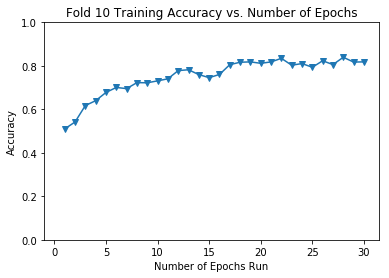

In [287]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_10f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 10 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

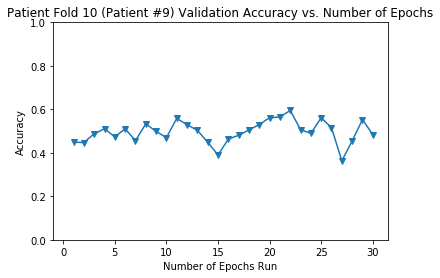

In [288]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_10f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 10 (Patient #9) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [289]:
# Eleventh Patient (Patient 1)
graph_seed = 42
reset_graph(graph_seed)

In [290]:
# Eleventh Validation Fold (Patient 1)
X_valid_fold = X_sorted[validation_11]
y_valid_fold = y_sorted[validation_11]

In [291]:
X_valid_fold.shape

(190, 251502)

In [292]:
y_valid_fold.shape

(190,)

In [293]:
# Validation Cube for patient fold 11
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_11_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [294]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [295]:
# Eleventh Training Fold (Patients 13,10,9,6,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_11]
y_train_fold = y_sorted[training_11]

In [296]:
X_train_fold.shape

(6460, 251502)

In [297]:
y_train_fold.shape

(6460,)

In [298]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [299]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [300]:
n_iterations_per_epoch

64

In [301]:
# Trains the CNN
acc_train_mat_11f = []
acc_valid_mat_11f = []

y_pred_valid_mat_11f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_11f.append(acc_train)
        acc_valid_mat_11f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_11f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_11f.append(y_pred_valid_11f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_11fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 23:05:17.216808 

Epoch 0
Last Batch accuracy:  50.00 %, Training accuracy:  51.55 %, Validation accuracy:  72.11 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  49  seconds.
Epoch 1
Last Batch accuracy:  57.00 %, Training accuracy:  58.95 %, Validation accuracy:  87.37 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  37  seconds.
Epoch 2
Last Batch accuracy:  62.00 %, Training accuracy:  57.38 %, Validation accuracy:  90.00 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  25  seconds.
Epoch 3
Last Batch accuracy:  67.00 %, Training accuracy:  52.49 %, Validation accuracy:  74.21 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  13  seconds.
Epoch 4
Last Batch accuracy:  63.00 %, Training accuracy:  54.32 %, Validation accuracy:  61.05 %
Time training up to Epoch  4 :  0  hours,  4  minutes, and  2  seconds.
Epoch 5
Last Batch accuracy:  58.00 %, Training accuracy:  63.78 %, Validation accuracy:  49.47 %
Time t

In [302]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Eleventh Patient Fold (Patient #1) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Eleventh Patient Fold (Patient #1) of CV took 0  hours,  24  minutes, and  5  seconds to train.



In [303]:
valid_accuracy_11f = accuracy_score(y_valid_fold, y_pred_valid_11f)
valid_precision_11f = precision_score(y_valid_fold, y_pred_valid_11f)
valid_recall_11f = recall_score(y_valid_fold, y_pred_valid_11f)
valid_f1_11f = f1_score(y_valid_fold, y_pred_valid_11f)

print("Segment Validation Statistics, Eleventh Patient Fold:\nAccuracy:\t\t",valid_accuracy_11f,
      "\nPrecision:\t\t",valid_precision_11f)
print("Recall:\t\t\t",valid_recall_11f,"\nF1 Score:\t\t",valid_f1_11f)

Segment Validation Statistics, Eleventh Patient Fold:
Accuracy:		 0.7263157894736842 
Precision:		 0.59375
Recall:			 1.0 
F1 Score:		 0.7450980392156863


In [304]:
valid_label = np.unique(y_valid_fold)
validation_cm_11f = confusion_matrix(y_valid_fold, y_pred_valid_11f, labels=valid_label) 

print("Eleventh Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_11f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Eleventh Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 62                 52
true:Nonleasional               0                 76


In [305]:
y_valid_cube_pred_11fold = group_hypercube(y_pred_valid_11f, cube_threshold, 
                                          validation_11_key, total_bands)

In [306]:
valid_accuracy_cube_11f = accuracy_score(y_valid_cube, y_valid_cube_pred_11fold)
valid_precision_cube_11f = precision_score(y_valid_cube, y_valid_cube_pred_11fold)
valid_recall_cube_11f = recall_score(y_valid_cube, y_valid_cube_pred_11fold)
valid_f1_cube_11f = f1_score(y_valid_cube, y_valid_cube_pred_11fold)

print("Validation Model Hypercube Statistics, Eleventh Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_11f,
      "\nHypercube Precision:\t\t",valid_precision_cube_11f)
print("Hypercube Recall: \t\t",valid_recall_cube_11f,"\nHypercube F1 Score:\t\t",valid_f1_cube_11f)

Validation Model Hypercube Statistics, Eleventh Patient Fold:
Hypercube Accuracy:		 0.8 
Hypercube Precision:		 0.6666666666666666
Hypercube Recall: 		 1.0 
Hypercube F1 Score:		 0.8


In [307]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_11f = confusion_matrix(y_valid_cube, y_valid_cube_pred_11fold, labels=valid_cube_label) 

print("Eleventh Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_11f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Eleventh Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  2                  1
true:Nonleasional               0                  2


In [308]:
avg_v_acc_11f, avg_v_prec_11f, avg_v_re_11f, avg_v_f1_11f, avg_v_cm_11f = average_runs(averaged_runs, 
                                                                                       y_pred_valid_mat_11f, y_valid_fold)

In [309]:
print("Average (20 Epochs) Segment Validation Statistics, Eleventh Patient Fold:\nAccuracy:\t\t",avg_v_acc_11f,
      "\nPrecision:\t\t",avg_v_prec_11f)
print("Recall:\t\t\t",avg_v_re_11f,"\nF1 Score:\t\t",avg_v_f1_11f)

Average (20 Epochs) Segment Validation Statistics, Eleventh Patient Fold:
Accuracy:		 0.6434210526315791 
Precision:		 0.5416952103969505
Recall:			 0.9901315789473685 
F1 Score:		 0.6965604421800968


In [310]:
avgvalid_cm_11f =  avg_v_cm_11f.groupby(avg_v_cm_11f.index)

avgvalid_cm_11f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,47.00,67.00
true:Nonleasional,0.75,75.25


In [311]:
avg_vc_acc_11f, avg_vc_prec_11f, avg_vc_re_11f, avg_vc_f1_11f, avg_vc_cm_11f = average_group_runs(averaged_runs,
                                                                                                  y_valid_cube,
                                                                                                  y_pred_valid_mat_11f,
                                                                                                  cube_threshold, 
                                                                                                  validation_11_key,
                                                                                                  total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Eleventh Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_11f,
      "\nHypercube Precision:\t\t",avg_vc_prec_11f)
print("Hypercube Recall:\t\t",avg_vc_re_11f,"\nHypercube F1 Score:\t\t",avg_vc_f1_11f)


Average (20 Epochs) Hypercube Validation Statistics, Eleventh Patient Fold:
Hypercube Accuracy:		 0.67 
Hypercube Precision:		 0.5883333333333333
Hypercube Recall:		 1.0 
Hypercube F1 Score:		 0.7276190476190476


In [312]:
avgvalid_cm_cube_11f =  avg_vc_cm_11f.groupby(avg_vc_cm_11f.index)

avgvalid_cm_cube_11f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,1.35,1.65
true:Nonleasional,0.00,2.00


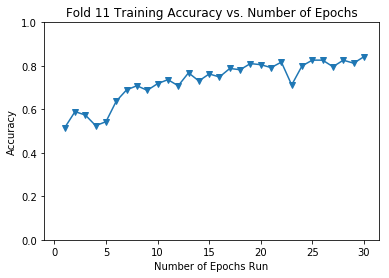

In [313]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_11f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 11 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

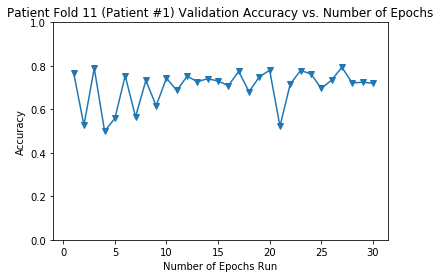

In [314]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_3f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 11 (Patient #1) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [315]:
# Twelfth Patient (Patient #10)
graph_seed = 42
reset_graph(graph_seed)

In [316]:
# Twelfth Validation Fold (Patient #10)
X_valid_fold = X_sorted[validation_12]
y_valid_fold = y_sorted[validation_12]

In [317]:
X_valid_fold.shape

(760, 251502)

In [318]:
y_valid_fold.shape

(760,)

In [319]:
# Validation Cube for patient fold 12 (Patient #10)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_12_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [320]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [321]:
# Fourth Training Fold (Patients 13,1,9,6,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_12]
y_train_fold = y_sorted[training_12]

In [322]:
X_train_fold.shape

(5890, 251502)

In [323]:
y_train_fold.shape

(5890,)

In [324]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [325]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [326]:
n_iterations_per_epoch

58

In [327]:
# Trains the CNN
acc_train_mat_12f = []
acc_valid_mat_12f = []

y_pred_valid_mat_12f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_12f.append(acc_train)
        acc_valid_mat_12f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_12f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_12f.append(y_pred_valid_12f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_12fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 23:30:28.553810 

Epoch 0
Last Batch accuracy:  51.00 %, Training accuracy:  50.46 %, Validation accuracy:  45.53 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  47  seconds.
Epoch 1
Last Batch accuracy:  52.00 %, Training accuracy:  54.04 %, Validation accuracy:  40.00 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  32  seconds.
Epoch 2
Last Batch accuracy:  47.00 %, Training accuracy:  51.00 %, Validation accuracy:  43.55 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  17  seconds.
Epoch 3
Last Batch accuracy:  55.00 %, Training accuracy:  54.47 %, Validation accuracy:  45.00 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  2  seconds.
Epoch 4
Last Batch accuracy:  54.00 %, Training accuracy:  53.58 %, Validation accuracy:  43.16 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  46  seconds.
Epoch 5
Last Batch accuracy:  50.00 %, Training accuracy:  52.58 %, Validation accuracy:  22.11 %
Time t

In [328]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Twelfth Patient Fold (Patient #10) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Twelfth Patient Fold (Patient #10) of CV took 0  hours,  22  minutes, and  23  seconds to train.



In [329]:
valid_accuracy_12f = accuracy_score(y_valid_fold, y_pred_valid_12f)
valid_precision_12f = precision_score(y_valid_fold, y_pred_valid_12f)
valid_recall_12f = recall_score(y_valid_fold, y_pred_valid_12f)
valid_f1_12f = f1_score(y_valid_fold, y_pred_valid_12f)

print("Segment Validation Statistics, Twelfth Patient Fold:\nAccuracy:\t\t",valid_accuracy_12f,
      "\nPrecision:\t\t",valid_precision_12f)
print("Recall:\t\t\t",valid_recall_12f,"\nF1 Score:\t\t",valid_f1_12f)

Segment Validation Statistics, Twelfth Patient Fold:
Accuracy:		 0.3960526315789474 
Precision:		 0.4966887417218543
Recall:			 0.4934210526315789 
F1 Score:		 0.49504950495049505


In [330]:
valid_label = np.unique(y_valid_fold)
validation_cm_12f = confusion_matrix(y_valid_fold, y_pred_valid_12f, labels=valid_label) 

print("Twelfth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_12f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Twelfth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                 76                228
true:Nonleasional             231                225


In [331]:
y_valid_cube_pred_12fold = group_hypercube(y_pred_valid_12f, cube_threshold, 
                                          validation_12_key, total_bands)

In [332]:
valid_accuracy_cube_12f = accuracy_score(y_valid_cube, y_valid_cube_pred_12fold)
valid_precision_cube_12f = precision_score(y_valid_cube, y_valid_cube_pred_12fold)
valid_recall_cube_12f = recall_score(y_valid_cube, y_valid_cube_pred_12fold)
valid_f1_cube_12f = f1_score(y_valid_cube, y_valid_cube_pred_12fold)

print("Validation Model Hypercube Statistics, Twelfth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_12f,
      "\nHypercube Precision:\t\t",valid_precision_cube_12f)
print("Hypercube Recall: \t\t",valid_recall_cube_12f,"\nHypercube F1 Score:\t\t",valid_f1_cube_12f)

Validation Model Hypercube Statistics, Twelfth Patient Fold:
Hypercube Accuracy:		 0.45 
Hypercube Precision:		 0.5384615384615384
Hypercube Recall: 		 0.5833333333333334 
Hypercube F1 Score:		 0.5599999999999999


In [333]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_12f = confusion_matrix(y_valid_cube, y_valid_cube_pred_12fold, labels=valid_cube_label) 

print("Twelfth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_12f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Twelfth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  2                  6
true:Nonleasional               5                  7


In [334]:
avg_v_acc_12f, avg_v_prec_12f, avg_v_re_12f, avg_v_f1_12f, avg_v_cm_12f = average_runs(averaged_runs, 
                                                                                       y_pred_valid_mat_12f, y_valid_fold)

In [335]:
print("Average (20 Epochs) Segment Validation Statistics, Twelfth Patient Fold:\nAccuracy:\t\t",avg_v_acc_12f,
      "\nPrecision:\t\t",avg_v_prec_12f)
print("Recall:\t\t\t",avg_v_re_12f,"\nF1 Score:\t\t",avg_v_f1_12f)

Average (20 Epochs) Segment Validation Statistics, Twelfth Patient Fold:
Accuracy:		 0.5522368421052631 
Precision:		 0.826271931392999
Recall:			 0.3620614035087719 
F1 Score:		 0.4890100452682399


In [336]:
avgvalid_cm_12f =  avg_v_cm_12f.groupby(avg_v_cm_12f.index)

avgvalid_cm_12f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,254.6,49.4
true:Nonleasional,290.9,165.1


In [337]:
avg_vc_acc_12f, avg_vc_prec_12f, avg_vc_re_12f, avg_vc_f1_12f, avg_vc_cm_12f = average_group_runs(averaged_runs,
                                                                                                  y_valid_cube, 
                                                                                                  y_pred_valid_mat_12f,
                                                                                                  cube_threshold, 
                                                                                                  validation_12_key, 
                                                                                                  total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Twelfth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_12f,
      "\nHypercube Precision:\t\t",avg_vc_prec_12f)
print("Hypercube Recall:\t\t",avg_vc_re_12f,"\nHypercube F1 Score:\t\t",avg_vc_f1_12f)


Average (20 Epochs) Hypercube Validation Statistics, Twelfth Patient Fold:
Hypercube Accuracy:		 0.5675000000000001 
Hypercube Precision:		 0.8927777777777779
Hypercube Recall:		 0.35416666666666663 
Hypercube F1 Score:		 0.4935574229691877


In [338]:
avgvalid_cm_cube_12f =  avg_vc_cm_12f.groupby(avg_vc_cm_12f.index)

avgvalid_cm_cube_12f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,7.10,0.90
true:Nonleasional,7.75,4.25


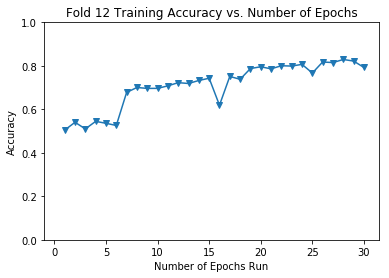

In [339]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_12f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 12 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

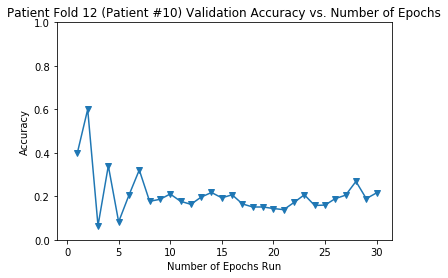

In [340]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_4f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 12 (Patient #10) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [341]:
# Thirteenth Patient (Patient #13)
graph_seed = 42
reset_graph(graph_seed)

In [342]:
# Thirteenth Validation Fold (Patient #13)
X_valid_fold = X_sorted[validation_13]
y_valid_fold = y_sorted[validation_13]

In [343]:
X_valid_fold.shape

(418, 251502)

In [344]:
y_valid_fold.shape

(418,)

In [345]:
# Validation Cube for patient fold 13 (Patient #13)
y_valid_cube = np.array([],dtype=np.int16)
for cube in validation_13_key:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_valid_cube = np.append(y_valid_cube,cube_class)

In [346]:
# Reset the training fold so the system memory is not overused
X_train_fold = []

In [347]:
# Thirteenth Training Fold (Patients 10,1,9,6,3,2,14,5,8,12,4,7)
X_train_fold = X_sorted[training_13]
y_train_fold = y_sorted[training_13]

In [348]:
X_train_fold.shape

(6232, 251502)

In [349]:
y_train_fold.shape

(6232,)

In [350]:
# Sets the Neural Network for the graph
height = 501
width = 502
channels = 1
n_inputs = height * width * channels


conv1_fmaps = 24
conv1_ksize = 5
conv1_stride = 3
conv1_pad = "SAME"
conv1_dropout_rate = 0.25

pool2_fmaps = conv1_fmaps

conv3_fmaps = 48
conv3_ksize = 3
conv3_stride = 1
conv3_pad = "SAME"
conv3_dropout_rate = 0.25

pool4_fmaps = conv3_fmaps

conv5_fmaps = 64
conv5_ksize = 2
conv5_stride = 1
conv5_pad = "SAME"
conv5_dropout_rate = 0.5

pool6_fmaps = conv5_fmaps

n_fc1 = 24
n_outputs = 2

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.tanh, kernel_regularizer=regularizer, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool2_drop = tf.layers.dropout(pool2, conv1_dropout_rate, training=training)

conv3 = tf.layers.conv2d(pool2_drop, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.tanh, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool4_drop = tf.layers.dropout(pool4, conv3_dropout_rate, training=training)

conv5 = tf.layers.conv2d(pool4_drop, filters=conv5_fmaps, kernel_size=conv5_ksize,
                         strides=conv5_stride, padding=conv5_pad,
                         activation=tf.nn.tanh, name="conv5")

with tf.name_scope("pool6"):
    pool6 = tf.nn.max_pool(conv5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool6_flat = tf.reshape(pool6, shape=[-1, pool6_fmaps * 20 * 21])
    pool6_flat_drop = tf.layers.dropout(pool6_flat, conv5_dropout_rate, training=training)      
       
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool6_flat_drop, n_fc1, activation=tf.nn.tanh, kernel_regularizer=regularizer, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    l2_loss = tf.losses.get_regularization_loss()
    loss = tf.reduce_mean(xentropy) + l2_loss
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [351]:
# Sets the number of epochs and batch size
n_iterations_per_epoch = len(X_train_fold) // batch_size

In [352]:
n_iterations_per_epoch

62

In [353]:
# Trains the CNN
acc_train_mat_13f = []
acc_valid_mat_13f = []

y_pred_valid_mat_13f = []

training_start_time = datetime.datetime.now()
print("Start Time: ", training_start_time, "\n")

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        y_train_pred = np.array([],dtype=np.int16)
        print("Epoch", epoch)
        # 
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = prepare_batch(X_train_fold, y_train_fold, batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        # Finds the predicted values for the training set
        for i in range(len((X_train_fold))):
            X_train = normalize_max_train(X_train_fold[i])
            z_pred_train = logits.eval(feed_dict={X: X_train})
            y_pred_train = np.argmax(z_pred_train, axis=1)
            y_train_pred = np.append(y_train_pred,y_pred_train)
        acc_train = accuracy_score(y_train_fold, y_train_pred)
        acc_val = accuracy.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        # Appends the network accuracy to a matrix for so we can evaluate performance over epoch
        acc_train_mat_13f.append(acc_train)
        acc_valid_mat_13f.append(acc_val)
        # Finds the predicted values for the validation set
        z_pred_valid = logits.eval(feed_dict={X: X_valid_fold, y: y_valid_fold})
        y_pred_valid_13f = np.argmax(z_pred_valid, axis=1)
        y_pred_valid_mat_13f.append(y_pred_valid_13f)
        
        training_duration_time = datetime.datetime.now()
        training_duration = training_duration_time-training_start_time
        training_hours, remainder = divmod(training_duration.seconds, 3600)
        training_minutes, training_seconds = divmod(remainder,60)
        print("Last Batch accuracy: ", "{0:.2f}".format(acc_batch*100),
              "%, Training accuracy: ", "{0:.2f}".format(acc_train*100),
              "%, Validation accuracy: ", "{0:.2f}".format(acc_val*100),"%")
        print("Time training up to Epoch ",epoch,": ",training_hours," hours, ", training_minutes,
              " minutes, and ", training_seconds, " seconds.")
    save_path = saver.save(sess, "./IB_maxdata_baseneta_100tanh_13fold_run1")
training_end_time = datetime.datetime.now()
print('\nTraining Complete:', training_end_time)

Start Time:  2019-03-07 23:53:51.460969 

Epoch 0
Last Batch accuracy:  49.00 %, Training accuracy:  52.68 %, Validation accuracy:  51.67 %
Time training up to Epoch  0 :  0  hours,  0  minutes, and  48  seconds.
Epoch 1
Last Batch accuracy:  50.00 %, Training accuracy:  50.06 %, Validation accuracy:  55.02 %
Time training up to Epoch  1 :  0  hours,  1  minutes, and  34  seconds.
Epoch 2
Last Batch accuracy:  60.00 %, Training accuracy:  58.14 %, Validation accuracy:  52.63 %
Time training up to Epoch  2 :  0  hours,  2  minutes, and  21  seconds.
Epoch 3
Last Batch accuracy:  56.00 %, Training accuracy:  56.11 %, Validation accuracy:  62.44 %
Time training up to Epoch  3 :  0  hours,  3  minutes, and  7  seconds.
Epoch 4
Last Batch accuracy:  56.00 %, Training accuracy:  63.46 %, Validation accuracy:  61.72 %
Time training up to Epoch  4 :  0  hours,  3  minutes, and  53  seconds.
Epoch 5
Last Batch accuracy:  66.00 %, Training accuracy:  62.76 %, Validation accuracy:  68.66 %
Time t

In [354]:
training_duration = training_end_time-training_start_time
duration_hours, duration_remainder = divmod(training_duration.seconds, 3600)
duration_minutes, duration_seconds = divmod(duration_remainder,60)
print("Thirteenth Patient Fold (Patient #13) of CV took",duration_hours," hours, ", duration_minutes,
              " minutes, and ", duration_seconds, " seconds to train.\n")

Thirteenth Patient Fold (Patient #13) of CV took 0  hours,  23  minutes, and  10  seconds to train.



In [355]:
valid_accuracy_13f = accuracy_score(y_valid_fold, y_pred_valid_13f)
valid_precision_13f = precision_score(y_valid_fold, y_pred_valid_13f)
valid_recall_13f = recall_score(y_valid_fold, y_pred_valid_13f)
valid_f1_13f = f1_score(y_valid_fold, y_pred_valid_13f)

print("Segment Validation Statistics, Thirteenth Patient Fold:\nAccuracy:\t\t",valid_accuracy_13f,
      "\nPrecision:\t\t",valid_precision_13f)
print("Recall:\t\t\t",valid_recall_13f,"\nF1 Score:\t\t",valid_f1_13f)

Segment Validation Statistics, Thirteenth Patient Fold:
Accuracy:		 0.6339712918660287 
Precision:		 0.6666666666666666
Recall:			 0.6578947368421053 
F1 Score:		 0.6622516556291391


In [356]:
valid_label = np.unique(y_valid_fold)
validation_cm_13f = confusion_matrix(y_valid_fold, y_pred_valid_13f, labels=valid_label) 

print("Thirteenth Patient Fold Validation Confusion Matrix:")
print(pd.DataFrame(validation_cm_13f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Thirteenth Patient Fold Validation Confusion Matrix:
                   pred:Leasional  pred:Nonleasional
true:Leasional                115                 75
true:Nonleasional              78                150


In [357]:
y_valid_cube_pred_13fold = group_hypercube(y_pred_valid_13f, cube_threshold,
                                           validation_13_key, total_bands)

In [358]:
valid_accuracy_cube_13f = accuracy_score(y_valid_cube, y_valid_cube_pred_13fold)
valid_precision_cube_13f = precision_score(y_valid_cube, y_valid_cube_pred_13fold)
valid_recall_cube_13f = recall_score(y_valid_cube, y_valid_cube_pred_13fold)
valid_f1_cube_13f = f1_score(y_valid_cube, y_valid_cube_pred_13fold)

print("Validation Model Hypercube Statistics, Thirteenth Patient Fold:\nHypercube Accuracy:\t\t",valid_accuracy_cube_13f,
      "\nHypercube Precision:\t\t",valid_precision_cube_13f)
print("Hypercube Recall: \t\t",valid_recall_cube_13f,"\nHypercube F1 Score:\t\t",valid_f1_cube_13f)

Validation Model Hypercube Statistics, Thirteenth Patient Fold:
Hypercube Accuracy:		 0.5454545454545454 
Hypercube Precision:		 0.5714285714285714
Hypercube Recall: 		 0.6666666666666666 
Hypercube F1 Score:		 0.6153846153846153


In [359]:
valid_cube_label = np.unique(y_valid_cube)
validation_cm_cube_13f = confusion_matrix(y_valid_cube, y_valid_cube_pred_13fold, labels=valid_cube_label) 

print("Thirteenth Patient Fold Validation Confusion Matrix (Cube):")
print(pd.DataFrame(validation_cm_cube_13f, index=['true:Leasional', 'true:Nonleasional'], 
                   columns=['pred:Leasional', 'pred:Nonleasional']))

Thirteenth Patient Fold Validation Confusion Matrix (Cube):
                   pred:Leasional  pred:Nonleasional
true:Leasional                  2                  3
true:Nonleasional               2                  4


In [360]:
avg_v_acc_13f, avg_v_prec_13f, avg_v_re_13f, avg_v_f1_13f, avg_v_cm_13f = average_runs(averaged_runs, 
                                                                                       y_pred_valid_mat_13f, y_valid_fold)

In [361]:
print("Average (20 Epochs) Segment Validation Statistics, Thirteenth Patient Fold:\nAccuracy:\t\t",avg_v_acc_13f,
      "\nPrecision:\t\t",avg_v_prec_13f)
print("Recall:\t\t\t",avg_v_re_13f,"\nF1 Score:\t\t",avg_v_f1_13f)

Average (20 Epochs) Segment Validation Statistics, Thirteenth Patient Fold:
Accuracy:		 0.5577751196172248 
Precision:		 0.5924239689236558
Recall:			 0.6453947368421054 
F1 Score:		 0.6161291345110367


In [362]:
avgvalid_cm_13f =  avg_v_cm_13f.groupby(avg_v_cm_13f.index)

avgvalid_cm_13f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,86.00,104.00
true:Nonleasional,80.85,147.15


In [363]:
avg_vc_acc_13f, avg_vc_prec_13f, avg_vc_re_13f, avg_vc_f1_13f, avg_vc_cm_13f = average_group_runs(averaged_runs,
                                                                                                  y_valid_cube, 
                                                                                                  y_pred_valid_mat_13f, 
                                                                                                  cube_threshold, 
                                                                                                  validation_13_key,
                                                                                                  total_bands)
print("Average (20 Epochs) Hypercube Validation Statistics, Thirteenth Patient Fold:\nHypercube Accuracy:\t\t",avg_vc_acc_13f,
      "\nHypercube Precision:\t\t",avg_vc_prec_13f)
print("Hypercube Recall:\t\t",avg_vc_re_13f,"\nHypercube F1 Score:\t\t",avg_vc_f1_13f)


Average (20 Epochs) Hypercube Validation Statistics, Thirteenth Patient Fold:
Hypercube Accuracy:		 0.5363636363636364 
Hypercube Precision:		 0.5796031746031746
Hypercube Recall:		 0.6666666666666665 
Hypercube F1 Score:		 0.6155111555111554


In [364]:
avgvalid_cm_cube_13f =  avg_vc_cm_13f.groupby(avg_vc_cm_13f.index)

avgvalid_cm_cube_13f.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,1.9,3.1
true:Nonleasional,2.0,4.0


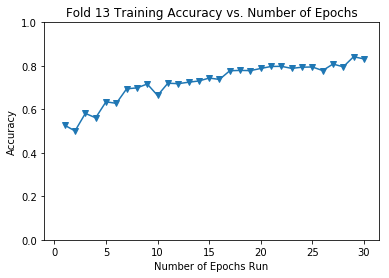

In [365]:
# Plot of Epochs vs Training Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_train_mat_13f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Fold 13 Training Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

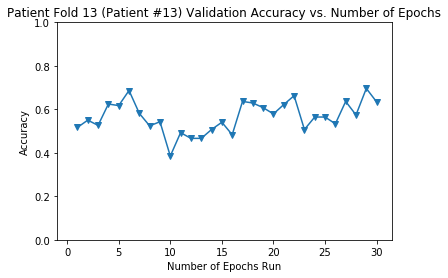

In [366]:
# Plot of Epochs vs Validation Accuracy

plt.plot(np.arange(1,epoch+2),np.array(acc_valid_mat_13f), '-v')
plt.xlabel('Number of Epochs Run')
plt.ylabel('Accuracy')
plt.title('Patient Fold 13 (Patient #13) Validation Accuracy vs. Number of Epochs')
plt.xlim(left=-1);
plt.ylim(top=1);
plt.ylim(bottom=0);

In [367]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [368]:
# CV Summary - Validation Segment Statistics
print("Validation Segment Statistics:")
print("Segment Accuracy:")
print("Patient 7:\t", "{0:.6f}".format(valid_accuracy_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_accuracy_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_accuracy_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_accuracy_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_accuracy_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_accuracy_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_accuracy_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_accuracy_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_accuracy_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_accuracy_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_accuracy_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_accuracy_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_accuracy_13f))

val_accuracy_total = (valid_accuracy_1f+valid_accuracy_2f+valid_accuracy_3f+valid_accuracy_4f+valid_accuracy_5f+
                      valid_accuracy_6f+valid_accuracy_7f+valid_accuracy_8f+valid_accuracy_9f+valid_accuracy_10f+
                      valid_accuracy_11f+valid_accuracy_12f+valid_accuracy_13f)
val_accuracy_average = val_accuracy_total/13

print("Average Segment Accuracy:\t", val_accuracy_average)

Validation Segment Statistics:
Segment Accuracy:
Patient 7:	 0.676692 	Patient 4:	 0.458647
Patient 12:	 0.720222 	Patient 8:	 0.215789
Patient 5:	 0.685673 	Patient 14:	 0.768421
Patient 2:	 0.555556 	Patient 3:	 0.776316
Patient 6:	 0.394737 	Patient 9:	 0.484211
Patient 1:	 0.726316 	Patient 10:	 0.396053
Patient 13:	 0.633971
Average Segment Accuracy:	 0.5763539553705758


In [369]:
print("Segment Precision:")
print("Patient 7:\t", "{0:.6f}".format(valid_precision_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_precision_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_precision_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_precision_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_precision_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_precision_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_precision_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_precision_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_precision_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_precision_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_precision_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_precision_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_precision_13f))

val_precision_total = (valid_precision_1f+valid_precision_2f+valid_precision_3f+valid_precision_4f+valid_precision_5f+
                       valid_precision_6f+valid_precision_7f+valid_precision_8f+valid_precision_9f+valid_precision_10f+
                       valid_precision_11f+valid_precision_12f+valid_precision_13f)
val_precision_average = val_precision_total/13

print("Average Segment Precision:\t", val_precision_average)

Segment Precision:
Patient 7:	 0.468487 	Patient 4:	 0.432127
Patient 12:	 0.685185 	Patient 8:	 0.000000
Patient 5:	 0.725979 	Patient 14:	 0.793478
Patient 2:	 0.000000 	Patient 3:	 0.984127
Patient 6:	 0.495575 	Patient 9:	 0.589286
Patient 1:	 0.593750 	Patient 10:	 0.496689
Patient 13:	 0.666667
Average Segment Precision:	 0.5331807318132541


In [370]:
print("Segment Recall:")
print("Patient 7:\t", "{0:.6f}".format(valid_recall_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_recall_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_recall_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_recall_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_recall_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_recall_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_recall_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_recall_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_recall_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_recall_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_recall_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_recall_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_recall_13f))

val_recall_total = (valid_recall_1f+valid_recall_2f+valid_recall_3f+valid_recall_4f+valid_recall_5f+
                    valid_recall_6f+valid_recall_7f+valid_recall_8f+valid_recall_9f+valid_recall_10f+
                    valid_recall_11f+valid_recall_12f+valid_recall_13f)
val_recall_average = val_recall_total/13

print("Average Segment Recall:\t", val_recall_average)

Segment Recall:
Patient 7:	 0.978070 	Patient 4:	 0.837719
Patient 12:	 0.757310 	Patient 8:	 0.000000
Patient 5:	 0.596491 	Patient 14:	 0.960526
Patient 2:	 0.000000 	Patient 3:	 0.652632
Patient 6:	 0.491228 	Patient 9:	 0.108553
Patient 1:	 1.000000 	Patient 10:	 0.493421
Patient 13:	 0.657895
Average Segment Recall:	 0.5795265407107513


In [371]:
print("Segment F1 Score:")
print("Patient 7:\t", "{0:.6f}".format(valid_f1_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_f1_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_f1_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_f1_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_f1_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_f1_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_f1_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_f1_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_f1_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_f1_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_f1_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_f1_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_f1_13f))

val_f1_total = (valid_f1_1f+valid_f1_2f+valid_f1_3f+valid_f1_4f+valid_f1_5f+valid_f1_6f+valid_f1_7f+
                valid_f1_8f+valid_f1_9f+valid_f1_10f+valid_f1_11f+valid_f1_12f+valid_f1_13f)
val_f1_average = val_f1_total/13

print("Average Segment F1 Score:\t", val_f1_average)

Segment F1 Score:
Patient 7:	 0.633523 	Patient 4:	 0.570149
Patient 12:	 0.719444 	Patient 8:	 0.000000
Patient 5:	 0.654896 	Patient 14:	 0.869048
Patient 2:	 0.000000 	Patient 3:	 0.784810
Patient 6:	 0.493392 	Patient 9:	 0.183333
Patient 1:	 0.745098 	Patient 10:	 0.495050
Patient 13:	 0.662252
Average Segment F1 Score:	 0.5239226492940976


In [372]:
valid_pd_cm_1f = pd.DataFrame(validation_cm_1f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_2f = pd.DataFrame(validation_cm_2f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_3f = pd.DataFrame(validation_cm_3f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_4f = pd.DataFrame(validation_cm_4f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_5f = pd.DataFrame(validation_cm_5f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_6f = pd.DataFrame(validation_cm_6f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_7f = pd.DataFrame(validation_cm_7f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_8f = pd.DataFrame(validation_cm_8f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_9f = pd.DataFrame(validation_cm_9f, index=['true:Leasional', 'true:Nonleasional'], 
                              columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_10f = pd.DataFrame(validation_cm_10f, index=['true:Leasional', 'true:Nonleasional'], 
                               columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_11f = pd.DataFrame(validation_cm_11f, index=['true:Leasional', 'true:Nonleasional'], 
                               columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_12f = pd.DataFrame(validation_cm_12f, index=['true:Leasional', 'true:Nonleasional'], 
                               columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_13f = pd.DataFrame(validation_cm_13f, index=['true:Leasional', 'true:Nonleasional'], 
                               columns=['pred:Leasional', 'pred:Nonleasional'])

In [373]:
# Sum Segment Validation Confusion Matrix
valid_concat = pd.concat((valid_pd_cm_1f,valid_pd_cm_2f,valid_pd_cm_3f,valid_pd_cm_4f,valid_pd_cm_5f,
                          valid_pd_cm_6f,valid_pd_cm_7f,valid_pd_cm_8f,valid_pd_cm_9f,valid_pd_cm_10f,
                          valid_pd_cm_11f,valid_pd_cm_12f,valid_pd_cm_13f))
validation_cm_group =  valid_concat.groupby(valid_concat.index)

validation_cm_group.sum()

,pred:Leasional,pred:Nonleasional
true:Leasional,1855,1489
true:Nonleasional,1417,1889


In [374]:
y_segment_total = np.array([],dtype=np.int16)
y_segment_total = np.append(y_segment_total, y_pred_valid_13f)
y_segment_total = np.append(y_segment_total, y_pred_valid_12f)
y_segment_total = np.append(y_segment_total, y_pred_valid_11f)
y_segment_total = np.append(y_segment_total, y_pred_valid_10f)
y_segment_total = np.append(y_segment_total, y_pred_valid_9f)
y_segment_total = np.append(y_segment_total, y_pred_valid_8f)
y_segment_total = np.append(y_segment_total, y_pred_valid_7f)
y_segment_total = np.append(y_segment_total, y_pred_valid_6f)
y_segment_total = np.append(y_segment_total, y_pred_valid_5f)
y_segment_total = np.append(y_segment_total, y_pred_valid_4f)
y_segment_total = np.append(y_segment_total, y_pred_valid_3f)
y_segment_total = np.append(y_segment_total, y_pred_valid_2f)
y_segment_total = np.append(y_segment_total, y_pred_valid_1f)


In [375]:
valid_accuracy_overall = accuracy_score(y_sorted,y_segment_total)
valid_precision_overall = precision_score(y_sorted, y_segment_total)
valid_recall_overall = recall_score(y_sorted, y_segment_total)
valid_f1_overall = f1_score(y_sorted, y_segment_total)

print("Segment Validation Statistics, Overall Segment Statistics:\nAccuracy:\t\t",valid_accuracy_overall,
      "\nPrecision:\t\t",valid_precision_overall)
print("Recall:\t\t\t",valid_recall_overall,"\nF1 Score:\t\t",valid_f1_overall)

Segment Validation Statistics, Overall Segment Statistics:
Accuracy:		 0.5630075187969925 
Precision:		 0.559206631142688
Recall:			 0.5713853599516031 
F1 Score:		 0.5652304009575105


In [376]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [377]:
# CV Summary - Validation Segment Statistics (Averaged over the last 20 epochs)
print("Validation Segment Statistics:")
print("Segment Accuracy (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_v_acc_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_v_acc_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_v_acc_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_v_acc_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_v_acc_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_v_acc_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_v_acc_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_v_acc_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_v_acc_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_v_acc_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_v_acc_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_v_acc_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_v_acc_13f))

avg_val_accuracy_total = (avg_v_acc_1f+avg_v_acc_2f+avg_v_acc_3f+avg_v_acc_4f+avg_v_acc_5f+avg_v_acc_6f+
                          avg_v_acc_7f+avg_v_acc_8f+avg_v_acc_9f+avg_v_acc_10f+avg_v_acc_11f+avg_v_acc_12f+
                          avg_v_acc_13f)
avg_val_accuracy_average = avg_val_accuracy_total/13

print("Average of Segment Accuracy Averages:\t", avg_val_accuracy_average)

Validation Segment Statistics:
Segment Accuracy (Averaged over the last 20 epochs):
Patient 7:	 0.617105 	Patient 4:	 0.637688
Patient 12:	 0.726316 	Patient 8:	 0.183158
Patient 5:	 0.740205 	Patient 14:	 0.714605
Patient 2:	 0.499561 	Patient 3:	 0.803947
Patient 6:	 0.449605 	Patient 9:	 0.502193
Patient 1:	 0.643421 	Patient 10:	 0.552237
Patient 13:	 0.557775
Average of Segment Accuracy Averages:	 0.586755145439356


In [378]:
print("Segment Precision (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_v_prec_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_v_prec_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_v_prec_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_v_prec_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_v_prec_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_v_prec_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_v_prec_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_v_prec_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_v_prec_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_v_prec_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_v_prec_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_v_prec_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_v_prec_13f))

avg_val_precision_total = (avg_v_prec_1f+avg_v_prec_2f+avg_v_prec_3f+avg_v_prec_4f+avg_v_prec_5f+
                           avg_v_prec_6f+avg_v_prec_7f+avg_v_prec_8f+avg_v_prec_9f+avg_v_prec_10f+
                           avg_v_prec_11f+avg_v_prec_12f+avg_v_prec_13f)
avg_val_precision_average = avg_val_precision_total/13

print("Average of Segment Percision Averages:\t", avg_val_precision_average)

Segment Precision (Averaged over the last 20 epochs):
Patient 7:	 0.429041 	Patient 4:	 0.582987
Patient 12:	 0.737137 	Patient 8:	 0.027134
Patient 5:	 0.782534 	Patient 14:	 0.789530
Patient 2:	 0.458311 	Patient 3:	 0.938679
Patient 6:	 0.552320 	Patient 9:	 0.604041
Patient 1:	 0.541695 	Patient 10:	 0.826272
Patient 13:	 0.592424
Average of Segment Percision Averages:	 0.6047771763500507


In [379]:
print("Segment Recall (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_v_re_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_v_re_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_v_re_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_v_re_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_v_re_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_v_re_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_v_re_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_v_re_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_v_re_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_v_re_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_v_re_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_v_re_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_v_re_13f))

avg_val_recall_total = (avg_v_re_1f+avg_v_re_2f+avg_v_re_3f+avg_v_re_4f+avg_v_re_5f+avg_v_re_6f+
                        avg_v_re_7f+avg_v_re_8f+avg_v_re_9f+avg_v_re_10f+avg_v_re_11f+avg_v_re_12f+
                        avg_v_re_13f)
avg_val_recall_average = avg_val_recall_total/13

print("Average of Segment Recall Averages:\t", avg_val_recall_average)

Segment Recall (Averaged over the last 20 epochs):
Patient 7:	 0.981798 	Patient 4:	 0.525439
Patient 12:	 0.688304 	Patient 8:	 0.036623
Patient 5:	 0.660819 	Patient 14:	 0.877138
Patient 2:	 0.462829 	Patient 3:	 0.732895
Patient 6:	 0.414912 	Patient 9:	 0.266283
Patient 1:	 0.990132 	Patient 10:	 0.362061
Patient 13:	 0.645395
Average of Segment Recall Averages:	 0.5880482456140351


In [380]:
print("Segment F1 Score (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_v_f1_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_v_f1_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_v_f1_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_v_f1_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_v_f1_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_v_f1_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_v_f1_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_v_f1_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_v_f1_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_v_f1_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_v_f1_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_v_f1_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_v_f1_13f))

avg_val_f1_total = (avg_v_f1_1f+avg_v_f1_2f+avg_v_f1_3f+avg_v_f1_4f+avg_v_f1_5f+avg_v_f1_6f+
                    avg_v_f1_7f+avg_v_f1_8f+avg_v_f1_9f+avg_v_f1_10f+avg_v_f1_11f+avg_v_f1_12f+
                    avg_v_f1_13f)
avg_val_f1_average = avg_val_f1_total/13

print("Average of Segment F1 Averages:\t", avg_val_f1_average)

Segment F1 Score (Averaged over the last 20 epochs):
Patient 7:	 0.596036 	Patient 4:	 0.548677
Patient 12:	 0.700930 	Patient 8:	 0.031089
Patient 5:	 0.711502 	Patient 14:	 0.829226
Patient 2:	 0.338780 	Patient 3:	 0.819009
Patient 6:	 0.453061 	Patient 9:	 0.347520
Patient 1:	 0.696560 	Patient 10:	 0.489010
Patient 13:	 0.616129
Average of Segment F1 Averages:	 0.5521176309880651


In [381]:
# Average Segment Validation Confusion Matrix (Averaged over the last 20 epochs)
avg_valid_concat = pd.concat((avg_v_cm_1f,avg_v_cm_2f,avg_v_cm_3f,avg_v_cm_4f,avg_v_cm_5f,
                              avg_v_cm_6f,avg_v_cm_7f,avg_v_cm_8f,avg_v_cm_9f,avg_v_cm_10f,
                              avg_v_cm_11f,avg_v_cm_12f,avg_v_cm_13f))
avg_validation_cm_group =  avg_valid_concat.groupby(avg_valid_concat.index)

avg_validation_cm_group.sum()/20

,pred:Leasional,pred:Nonleasional
true:Leasional,2033.1,1310.9
true:Nonleasional,1453.3,1852.7


In [382]:
start_avg=epoch-averaged_runs

y_avg_seg_total_mat = np.array([],dtype=np.int16)

y_avg_seg_total = np.array([],dtype=np.int16)
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_13f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_12f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_11f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_10f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_9f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_8f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_7f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_6f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_5f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_4f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_3f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_2f[start_avg])
y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_1f[start_avg])
y_avg_seg_total_mat = np.append(y_avg_seg_total_mat, y_avg_seg_total)

for index in range(start_avg+1,epoch):
    y_avg_seg_total = np.array([],dtype=np.int16)
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_13f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_12f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_11f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_10f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_9f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_8f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_7f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_6f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_5f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_4f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_3f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_2f[index])
    y_avg_seg_total = np.append(y_avg_seg_total, y_pred_valid_mat_1f[index])
    y_avg_seg_total_mat = np.vstack((y_avg_seg_total_mat, y_avg_seg_total))

In [383]:
over_acc_mat = np.array([],dtype=np.int16)
over_prec_mat = np.array([],dtype=np.int16)
over_recall_mat = np.array([],dtype=np.int16)
over_f1_mat = np.array([],dtype=np.int16)
over_confuse_mat = []
for i in range(20):
    index_acc = accuracy_score(y_sorted, y_avg_seg_total_mat[i])
    over_acc_mat = np.append(over_acc_mat, index_acc)
    index_prec = precision_score(y_sorted, y_avg_seg_total_mat[i])
    over_prec_mat = np.append(over_prec_mat, index_prec)        
    index_recall = recall_score(y_sorted, y_avg_seg_total_mat[i])
    over_recall_mat = np.append(over_recall_mat, index_recall)        
    index_f1 = f1_score(y_sorted, y_avg_seg_total_mat[i])
    over_f1_mat = np.append(over_f1_mat, index_f1)
    cm_label = np.unique(y_sorted)
    index_cm = confusion_matrix(y_sorted, y_avg_seg_total_mat[i], labels=cm_label)
    pd_cm = pd.DataFrame(index_cm, index=['true:Leasional', 'true:Nonleasional'], 
                         columns=['pred:Leasional', 'pred:Nonleasional'])
    over_confuse_mat.append(pd_cm)
over_seg_avg_acc = np.mean(over_acc_mat)
over_seg_avg_prec = np.mean(over_prec_mat)
over_seg_avg_recall = np.mean(over_recall_mat)
over_seg_avg_f1 = np.mean(over_f1_mat)
over_seg_avg_cm = pd.concat(over_confuse_mat)

In [384]:
print("Average Validation Segment Statistics (Over 20 Epochs), Overall Segment Statistics:\nAccuracy:\t\t",over_seg_avg_acc,
      "\nPrecision:\t\t",over_seg_avg_prec)
print("Recall:\t\t\t",over_seg_avg_recall,"\nF1 Score:\t\t",over_seg_avg_f1)

Average Validation Segment Statistics (Over 20 Epochs), Overall Segment Statistics:
Accuracy:		 0.5843308270676693 
Precision:		 0.587073723255066
Recall:			 0.5604053236539625 
F1 Score:		 0.5723254183157879


In [385]:
over_seg_avg_cm =  over_seg_avg_cm.groupby(over_seg_avg_cm.index)

over_seg_avg_cm.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,2033.1,1310.9
true:Nonleasional,1453.3,1852.7


In [386]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [387]:
# CV Summary - Validation Hypercube Statistics
print("Validation Hypercube Statistics:")
print("Hypercube Accuracy:")
print("Patient 7:\t", "{0:.6f}".format(valid_accuracy_cube_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_accuracy_cube_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_accuracy_cube_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_accuracy_cube_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_accuracy_cube_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_accuracy_cube_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_accuracy_cube_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_accuracy_cube_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_accuracy_cube_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_accuracy_cube_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_accuracy_cube_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_accuracy_cube_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_accuracy_cube_13f))

val_accuracy_cube_total = (valid_accuracy_cube_1f+valid_accuracy_cube_2f+valid_accuracy_cube_3f+
                           valid_accuracy_cube_4f+valid_accuracy_cube_5f+valid_accuracy_cube_6f+
                           valid_accuracy_cube_7f+valid_accuracy_cube_8f+valid_accuracy_cube_9f+
                           valid_accuracy_cube_10f+valid_accuracy_cube_11f+valid_accuracy_cube_12f+
                           valid_accuracy_cube_13f)
val_accuracy_cube_average = val_accuracy_cube_total/13

print("Average Hypercube Accuracy:\t", val_accuracy_cube_average)

Validation Hypercube Statistics:
Hypercube Accuracy:
Patient 7:	 0.666667 	Patient 4:	 0.500000
Patient 12:	 0.684211 	Patient 8:	 0.133333
Patient 5:	 0.666667 	Patient 14:	 0.800000
Patient 2:	 0.555556 	Patient 3:	 0.750000
Patient 6:	 0.300000 	Patient 9:	 0.466667
Patient 1:	 0.800000 	Patient 10:	 0.450000
Patient 13:	 0.545455
Average Hypercube Accuracy:	 0.5629656892814787


In [388]:
print("Hypercube Precision:")
print("Patient 7:\t", "{0:.6f}".format(valid_precision_cube_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_precision_cube_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_precision_cube_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_precision_cube_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_precision_cube_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_precision_cube_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_precision_cube_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_precision_cube_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_precision_cube_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_precision_cube_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_precision_cube_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_precision_cube_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_precision_cube_13f))

val_precision_cube_total = (valid_precision_cube_1f+valid_precision_cube_2f+valid_precision_cube_3f+
                            valid_precision_cube_4f+valid_precision_cube_5f+valid_precision_cube_6f+
                            valid_precision_cube_7f+valid_precision_cube_8f+valid_precision_cube_9f+
                            valid_precision_cube_10f+valid_precision_cube_11f+valid_precision_cube_12f+
                            valid_precision_cube_13f)
val_precision_cube_average = val_precision_cube_total/13

print("Average Hypercube Precision:\t", val_precision_cube_average)

Hypercube Precision:
Patient 7:	 0.461538 	Patient 4:	 0.461538
Patient 12:	 0.636364 	Patient 8:	 0.000000
Patient 5:	 0.666667 	Patient 14:	 0.800000
Patient 2:	 0.000000 	Patient 3:	 1.000000
Patient 6:	 0.400000 	Patient 9:	 0.000000
Patient 1:	 0.666667 	Patient 10:	 0.538462
Patient 13:	 0.571429
Average Hypercube Precision:	 0.4771280002049233


In [389]:
print("Hypercube Recall:")
print("Patient 7:\t", "{0:.6f}".format(valid_recall_cube_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_recall_cube_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_recall_cube_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_recall_cube_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_recall_cube_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_recall_cube_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_recall_cube_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_recall_cube_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_recall_cube_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_recall_cube_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_recall_cube_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_recall_cube_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_recall_cube_13f))

val_recall_cube_total = (valid_recall_cube_1f+valid_recall_cube_2f+valid_recall_cube_3f+valid_recall_cube_4f+
                         valid_recall_cube_5f+valid_recall_cube_6f+valid_recall_cube_7f+valid_recall_cube_8f+
                         valid_recall_cube_9f+valid_recall_cube_10f+valid_recall_cube_11f+valid_recall_cube_12f+
                         valid_recall_cube_13f)
val_recall_cube_average = val_recall_cube_total/13

print("Average Hypercube Recall:\t", val_recall_cube_average)

Hypercube Recall:
Patient 7:	 1.000000 	Patient 4:	 1.000000
Patient 12:	 0.777778 	Patient 8:	 0.000000
Patient 5:	 0.666667 	Patient 14:	 1.000000
Patient 2:	 0.000000 	Patient 3:	 0.600000
Patient 6:	 0.333333 	Patient 9:	 0.000000
Patient 1:	 1.000000 	Patient 10:	 0.583333
Patient 13:	 0.666667
Average Hypercube Recall:	 0.5867521367521367


In [390]:
print("Hypercube F1 Score:")
print("Patient 7:\t", "{0:.6f}".format(valid_f1_cube_1f), "\tPatient 4:\t", "{0:.6f}".format(valid_f1_cube_2f))
print("Patient 12:\t", "{0:.6f}".format(valid_f1_cube_3f), "\tPatient 8:\t", "{0:.6f}".format(valid_f1_cube_4f))
print("Patient 5:\t", "{0:.6f}".format(valid_f1_cube_5f), "\tPatient 14:\t", "{0:.6f}".format(valid_f1_cube_6f))
print("Patient 2:\t", "{0:.6f}".format(valid_f1_cube_7f), "\tPatient 3:\t", "{0:.6f}".format(valid_f1_cube_8f))
print("Patient 6:\t", "{0:.6f}".format(valid_f1_cube_9f), "\tPatient 9:\t", "{0:.6f}".format(valid_f1_cube_10f))
print("Patient 1:\t", "{0:.6f}".format(valid_f1_cube_11f), "\tPatient 10:\t", "{0:.6f}".format(valid_f1_cube_12f))
print("Patient 13:\t", "{0:.6f}".format(valid_f1_cube_13f))

val_f1_cube_total = (valid_f1_cube_1f+valid_f1_cube_2f+valid_f1_cube_3f+valid_f1_cube_4f+valid_f1_cube_5f+
                     valid_f1_cube_6f+valid_f1_cube_7f+valid_f1_cube_8f+valid_f1_cube_9f+valid_f1_cube_10f+
                     valid_f1_cube_11f+valid_f1_cube_12f+valid_f1_cube_13f)
val_f1_cube_average = val_f1_total/13

print("Average Hypercube F1 Score:\t", val_f1_average)

Hypercube F1 Score:
Patient 7:	 0.631579 	Patient 4:	 0.631579
Patient 12:	 0.700000 	Patient 8:	 0.000000
Patient 5:	 0.666667 	Patient 14:	 0.888889
Patient 2:	 0.000000 	Patient 3:	 0.750000
Patient 6:	 0.363636 	Patient 9:	 0.000000
Patient 1:	 0.800000 	Patient 10:	 0.560000
Patient 13:	 0.615385
Average Hypercube F1 Score:	 0.5239226492940976


In [391]:

valid_pd_cm_cube_1f = pd.DataFrame(validation_cm_cube_1f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_2f = pd.DataFrame(validation_cm_cube_2f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_3f = pd.DataFrame(validation_cm_cube_3f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_4f = pd.DataFrame(validation_cm_cube_4f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_5f = pd.DataFrame(validation_cm_cube_5f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_6f = pd.DataFrame(validation_cm_cube_6f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_7f = pd.DataFrame(validation_cm_cube_7f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_8f = pd.DataFrame(validation_cm_cube_8f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_9f = pd.DataFrame(validation_cm_cube_9f, index=['true:Leasional', 'true:Nonleasional'], 
                                   columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_10f = pd.DataFrame(validation_cm_cube_10f, index=['true:Leasional', 'true:Nonleasional'], 
                                    columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_11f = pd.DataFrame(validation_cm_cube_11f, index=['true:Leasional', 'true:Nonleasional'], 
                                    columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_12f = pd.DataFrame(validation_cm_cube_12f, index=['true:Leasional', 'true:Nonleasional'], 
                                    columns=['pred:Leasional', 'pred:Nonleasional'])
valid_pd_cm_cube_13f = pd.DataFrame(validation_cm_cube_13f, index=['true:Leasional', 'true:Nonleasional'], 
                                    columns=['pred:Leasional', 'pred:Nonleasional'])

In [392]:
# Hypercube Validation Confusion Matrix 
print("Sum of Hypercube Confusion Matrices:")
valid_concat_cube = pd.concat((valid_pd_cm_cube_1f,valid_pd_cm_cube_2f,valid_pd_cm_cube_3f,valid_pd_cm_cube_4f,
                               valid_pd_cm_cube_5f,valid_pd_cm_cube_6f,valid_pd_cm_cube_7f,valid_pd_cm_cube_8f,
                               valid_pd_cm_cube_9f,valid_pd_cm_cube_10f,valid_pd_cm_cube_11f,valid_pd_cm_cube_12f,
                               valid_pd_cm_cube_13f))
validation_cm_group_cube =  valid_concat_cube.groupby(valid_concat_cube.index)

validation_cm_group_cube.sum()

Sum of Hypercube Confusion Matrices:


,pred:Leasional,pred:Nonleasional
true:Leasional,45,43
true:Nonleasional,36,51


In [393]:
# Overall Validation Cube
y_overall_cube = np.array([],dtype=np.int16)
for cube in hypercube_key_sorted:
    if cube.endswith('N'):
        cube_class = 1
    else:
        cube_class = 0
    y_overall_cube = np.append(y_overall_cube,cube_class)

In [395]:
y_overall_pred_cube = group_hypercube(y_segment_total, cube_threshold, hypercube_key_sorted, total_bands)

In [396]:
valid_accuracy_overall_cube = accuracy_score(y_overall_cube,y_overall_pred_cube)
valid_precision_overall_cube = precision_score(y_overall_cube, y_overall_pred_cube)
valid_recall_overall_cube = recall_score(y_overall_cube, y_overall_pred_cube)
valid_f1_overall_cube = f1_score(y_overall_cube, y_overall_pred_cube)

print("Validation Statistics, Overall Hypercube Statistics:\nAccuracy:\t\t",valid_accuracy_overall_cube,
      "\nPrecision:\t\t",valid_precision_overall_cube)
print("Recall:\t\t\t",valid_recall_overall_cube,"\nF1 Score:\t\t",valid_f1_overall_cube)

Validation Statistics, Overall Hypercube Statistics:
Accuracy:		 0.5485714285714286 
Precision:		 0.5425531914893617
Recall:			 0.5862068965517241 
F1 Score:		 0.56353591160221


In [397]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [398]:
# CV Summary - Validation Hypercube Statistics (Averaged over the last 20 epochs)
print("Validation Hypercube Statistics:")
print("Hypercube Accuracy (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_vc_acc_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_vc_acc_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_vc_acc_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_vc_acc_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_vc_acc_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_vc_acc_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_vc_acc_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_vc_acc_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_vc_acc_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_vc_acc_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_vc_acc_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_vc_acc_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_vc_acc_13f))

avg_val_accuracy_cube_total = (avg_vc_acc_1f+avg_vc_acc_2f+avg_vc_acc_3f+avg_vc_acc_4f+avg_vc_acc_5f+
                               avg_vc_acc_6f+avg_vc_acc_7f+avg_vc_acc_8f+avg_vc_acc_9f+avg_vc_acc_10f+
                               avg_vc_acc_11f+avg_vc_acc_12f+avg_vc_acc_13f)
avg_val_accuracy_cube_average = avg_val_accuracy_cube_total/13

print("Average of Hypercube Accuracy Averages:\t", avg_val_accuracy_cube_average)

Validation Hypercube Statistics:
Hypercube Accuracy (Averaged over the last 20 epochs):
Patient 7:	 0.642857 	Patient 4:	 0.721429
Patient 12:	 0.718421 	Patient 8:	 0.136667
Patient 5:	 0.769444 	Patient 14:	 0.780000
Patient 2:	 0.511111 	Patient 3:	 0.843750
Patient 6:	 0.450000 	Patient 9:	 0.546667
Patient 1:	 0.670000 	Patient 10:	 0.567500
Patient 13:	 0.536364
Average of Hypercube Accuracy Averages:	 0.6072468686284476


In [399]:
print("Hypercube Precision (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_vc_prec_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_vc_prec_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_vc_prec_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_vc_prec_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_vc_prec_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_vc_prec_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_vc_prec_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_vc_prec_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_vc_prec_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_vc_prec_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_vc_prec_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_vc_prec_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_vc_prec_13f))

avg_val_precision_cube_total = (avg_vc_prec_1f+avg_vc_prec_2f+avg_vc_prec_3f+avg_vc_prec_4f+avg_vc_prec_5f+
                                avg_vc_prec_6f+avg_vc_prec_7f+avg_vc_prec_8f+avg_vc_prec_9f+avg_vc_prec_10f+
                                avg_vc_prec_11f+avg_vc_prec_12f+avg_vc_prec_13f)
avg_val_precision_cube_average = avg_val_precision_cube_total/13

print("Average of Hypercube Precision Averages:\t", avg_val_precision_cube_average)

Hypercube Precision (Averaged over the last 20 epochs):
Patient 7:	 0.448775 	Patient 4:	 0.739881
Patient 12:	 0.736977 	Patient 8:	 0.017361
Patient 5:	 0.840317 	Patient 14:	 0.798750
Patient 2:	 0.304067 	Patient 3:	 1.000000
Patient 6:	 0.509048 	Patient 9:	 0.615794
Patient 1:	 0.588333 	Patient 10:	 0.892778
Patient 13:	 0.579603
Average of Hypercube Precision Averages:	 0.6208987700333854


In [400]:
print("Hypercube Recall (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_vc_re_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_vc_re_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_vc_re_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_vc_re_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_vc_re_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_vc_re_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_vc_re_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_vc_re_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_vc_re_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_vc_re_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_vc_re_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_vc_re_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_vc_re_13f))

avg_val_recall_cube_total = (avg_vc_re_1f+avg_vc_re_2f+avg_vc_re_3f+avg_vc_re_4f+avg_vc_re_5f+
                             avg_vc_re_6f+avg_vc_re_7f+avg_vc_re_8f+avg_vc_re_9f+avg_vc_re_10f+
                             avg_vc_re_11f+avg_vc_re_12f+avg_vc_re_13f)
avg_val_recall_cube_average = avg_val_recall_cube_total/13

print("Average of Hypercube Recall Averages:\t", avg_val_recall_cube_average)

Hypercube Recall (Averaged over the last 20 epochs):
Patient 7:	 0.991667 	Patient 4:	 0.541667
Patient 12:	 0.688889 	Patient 8:	 0.025000
Patient 5:	 0.666667 	Patient 14:	 0.968750
Patient 2:	 0.487500 	Patient 3:	 0.750000
Patient 6:	 0.450000 	Patient 9:	 0.262500
Patient 1:	 1.000000 	Patient 10:	 0.354167
Patient 13:	 0.666667
Average of Hypercube Recall Averages:	 0.6041132478632479


In [401]:
print("Hypercube F1 Score (Averaged over the last 20 epochs):")
print("Patient 7:\t", "{0:.6f}".format(avg_vc_f1_1f), "\tPatient 4:\t", "{0:.6f}".format(avg_vc_f1_2f))
print("Patient 12:\t", "{0:.6f}".format(avg_vc_f1_3f), "\tPatient 8:\t", "{0:.6f}".format(avg_vc_f1_4f))
print("Patient 5:\t", "{0:.6f}".format(avg_vc_f1_5f), "\tPatient 14:\t", "{0:.6f}".format(avg_vc_f1_6f))
print("Patient 2:\t", "{0:.6f}".format(avg_vc_f1_7f), "\tPatient 3:\t", "{0:.6f}".format(avg_vc_f1_8f))
print("Patient 6:\t", "{0:.6f}".format(avg_vc_f1_9f), "\tPatient 9:\t", "{0:.6f}".format(avg_vc_f1_10f))
print("Patient 1:\t", "{0:.6f}".format(avg_vc_f1_11f), "\tPatient 10:\t", "{0:.6f}".format(avg_vc_f1_12f))
print("Patient 13:\t", "{0:.6f}".format(avg_vc_f1_13f))

avg_val_f1_cube_total = (avg_vc_f1_1f+avg_vc_f1_2f+avg_vc_f1_3f+avg_vc_f1_4f+avg_vc_f1_5f+
                         avg_vc_f1_6f+avg_vc_f1_7f+avg_vc_f1_8f+avg_vc_f1_9f+avg_vc_f1_10f+
                         avg_vc_f1_11f+avg_vc_f1_12f+avg_vc_f1_13f)
avg_val_f1_cube_average = avg_val_f1_total/13

print("Average of Hypercube F1 Averages:\t", avg_val_f1_average)

Hypercube F1 Score (Averaged over the last 20 epochs):
Patient 7:	 0.616560 	Patient 4:	 0.620381
Patient 12:	 0.695835 	Patient 8:	 0.020476
Patient 5:	 0.736456 	Patient 14:	 0.874306
Patient 2:	 0.346229 	Patient 3:	 0.852778
Patient 6:	 0.462686 	Patient 9:	 0.342625
Patient 1:	 0.727619 	Patient 10:	 0.493557
Patient 13:	 0.615511
Average of Hypercube F1 Averages:	 0.5521176309880651


In [402]:
# Average Hypercube Validation Confusion Matrix
print("Sum of Averages of Hypercube Confusion Matrices:")
avg_valid_concat_cube = pd.concat((avg_vc_cm_1f,avg_vc_cm_2f,avg_vc_cm_3f,avg_vc_cm_4f,avg_vc_cm_5f,
                                   avg_vc_cm_6f,avg_vc_cm_7f,avg_vc_cm_8f,avg_vc_cm_9f,avg_vc_cm_10f,
                                   avg_vc_cm_11f,avg_vc_cm_12f,avg_vc_cm_13f))
avg_validation_cm_group_cube =  avg_valid_concat_cube.groupby(avg_valid_concat_cube.index)

avg_validation_cm_group_cube.sum()/20

Sum of Averages of Hypercube Confusion Matrices:


,pred:Leasional,pred:Nonleasional
true:Leasional,55.55,32.45
true:Nonleasional,36.95,50.05


In [403]:
over_acc_mat = np.array([],dtype=np.int16)
over_prec_mat = np.array([],dtype=np.int16)
over_recall_mat = np.array([],dtype=np.int16)
over_f1_mat = np.array([],dtype=np.int16)
over_confuse_mat = []
for i in range(20):
    y_overall_avg_cube = group_hypercube(y_avg_seg_total_mat[i], cube_threshold, hypercube_key_sorted, total_bands)
    index_acc = accuracy_score(y_overall_cube, y_overall_avg_cube)
    over_acc_mat = np.append(over_acc_mat, index_acc)
    index_prec = precision_score(y_overall_cube, y_overall_avg_cube)
    over_prec_mat = np.append(over_prec_mat, index_prec)        
    index_recall = recall_score(y_overall_cube, y_overall_avg_cube)
    over_recall_mat = np.append(over_recall_mat, index_recall)        
    index_f1 = f1_score(y_overall_cube, y_overall_avg_cube)
    over_f1_mat = np.append(over_f1_mat, index_f1)
    cm_label = np.unique(y_overall_cube)
    index_cm = confusion_matrix(y_overall_cube, y_overall_avg_cube, labels=cm_label)
    pd_cm = pd.DataFrame(index_cm, index=['true:Leasional', 'true:Nonleasional'], 
                         columns=['pred:Leasional', 'pred:Nonleasional'])
    over_confuse_mat.append(pd_cm)
over_cube_avg_acc = np.mean(over_acc_mat)
over_cube_avg_prec = np.mean(over_prec_mat)
over_cube_avg_recall = np.mean(over_recall_mat)
over_cube_avg_f1 = np.mean(over_f1_mat)
over_cube_avg_cm = pd.concat(over_confuse_mat)

In [404]:
print("Average Validation Segment Statistics (Over 20 Epochs), Overall Segment Statistics:\nAccuracy:\t\t",over_cube_avg_acc,
      "\nPrecision:\t\t",over_cube_avg_prec)
print("Recall:\t\t\t",over_cube_avg_recall,"\nF1 Score:\t\t",over_cube_avg_f1)

Average Validation Segment Statistics (Over 20 Epochs), Overall Segment Statistics:
Accuracy:		 0.6034285714285714 
Precision:		 0.6090331228541552
Recall:			 0.5752873563218391 
F1 Score:		 0.5903489314699786


In [405]:
over_cube_avg_cm =  over_cube_avg_cm.groupby(over_cube_avg_cm.index)

over_cube_avg_cm.mean()

,pred:Leasional,pred:Nonleasional
true:Leasional,55.55,32.45
true:Nonleasional,36.95,50.05


In [406]:
print('_________________________________________________________________________________________')

_________________________________________________________________________________________


In [407]:
print("Validation Run:\nSegment Summary (Averaged by Patient):\nAccuracy:\t\t",val_accuracy_average,
      "\nPrecision:\t\t",val_precision_average)
print("Recall:\t\t\t",val_recall_average,"\nF1 Score:\t\t",val_f1_average)

print("Segment Summary  (Averaged by Patient), Averaged over the last 20 epochs:\nAccuracy:\t\t",avg_val_accuracy_average,
      "\nPrecision:\t\t",avg_val_precision_average)
print("Recall:\t\t\t",avg_val_recall_average,"\nF1 Score:\t\t",avg_val_f1_average)

print("Hypercube Summary  (Averaged by Patient):\nAccuracy:\t\t",val_accuracy_cube_average,
      "\nPrecision:\t\t",val_precision_cube_average)
print("Recall:\t\t\t",val_recall_cube_average,"\nF1 Score:\t\t",val_f1_cube_average)

print("Hypercube Summary  (Averaged by Patient), Averaged over the last 20 epochs:\nAccuracy:\t\t",avg_val_accuracy_cube_average,
      "\nPrecision:\t\t",avg_val_precision_cube_average)
print("Recall:\t\t\t",avg_val_recall_cube_average,"\nF1 Score:\t\t",avg_val_f1_cube_average)

Validation Run:
Segment Summary (Averaged by Patient):
Accuracy:		 0.5763539553705758 
Precision:		 0.5331807318132541
Recall:			 0.5795265407107513 
F1 Score:		 0.5239226492940976
Segment Summary  (Averaged by Patient), Averaged over the last 20 epochs:
Accuracy:		 0.586755145439356 
Precision:		 0.6047771763500507
Recall:			 0.5880482456140351 
F1 Score:		 0.5521176309880651
Hypercube Summary  (Averaged by Patient):
Accuracy:		 0.5629656892814787 
Precision:		 0.4771280002049233
Recall:			 0.5867521367521367 
F1 Score:		 0.5239226492940976
Hypercube Summary  (Averaged by Patient), Averaged over the last 20 epochs:
Accuracy:		 0.6072468686284476 
Precision:		 0.6208987700333854
Recall:			 0.6041132478632479 
F1 Score:		 0.5521176309880651


In [408]:
print("Validation Run:\nSegment Summary (Overall):\nAccuracy:\t\t",valid_accuracy_overall,
      "\nPrecision:\t\t",valid_precision_overall)
print("Recall:\t\t\t",valid_recall_overall,"\nF1 Score:\t\t",valid_f1_overall)

print("Segment Summary  (Overall), Averaged over the last 20 epochs:\nAccuracy:\t\t",over_seg_avg_acc,
      "\nPrecision:\t\t",over_seg_avg_prec)
print("Recall:\t\t\t",over_seg_avg_recall,"\nF1 Score:\t\t",over_seg_avg_f1)

print("Hypercube Summary  (Overall):\nAccuracy:\t\t",valid_accuracy_overall_cube,
      "\nPrecision:\t\t",valid_precision_overall_cube)
print("Recall:\t\t\t",valid_recall_overall_cube,"\nF1 Score:\t\t",valid_f1_overall_cube)

print("Hypercube Summary  (Overall), Averaged over the last 20 epochs:\nAccuracy:\t\t",over_cube_avg_acc,
      "\nPrecision:\t\t",over_cube_avg_prec)
print("Recall:\t\t\t",over_cube_avg_recall,"\nF1 Score:\t\t",over_cube_avg_f1)

Validation Run:
Segment Summary (Overall):
Accuracy:		 0.5630075187969925 
Precision:		 0.559206631142688
Recall:			 0.5713853599516031 
F1 Score:		 0.5652304009575105
Segment Summary  (Overall), Averaged over the last 20 epochs:
Accuracy:		 0.5843308270676693 
Precision:		 0.587073723255066
Recall:			 0.5604053236539625 
F1 Score:		 0.5723254183157879
Hypercube Summary  (Overall):
Accuracy:		 0.5485714285714286 
Precision:		 0.5425531914893617
Recall:			 0.5862068965517241 
F1 Score:		 0.56353591160221
Hypercube Summary  (Overall), Averaged over the last 20 epochs:
Accuracy:		 0.6034285714285714 
Precision:		 0.6090331228541552
Recall:			 0.5752873563218391 
F1 Score:		 0.5903489314699786


In [409]:
hdf5_file.close()